# Project 2: COVID-19 Radiography Classification using Deep Learning


GitHub Repo: https://github.com/lz3073-oss/P2_G4-Project_2.git

In [51]:
from IPython.display import Image
from IPython.core.display import HTML

## 

## Data Cleaning and Preprocess

In [56]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [57]:
# Suppress TensorFlow warnings and GPU messages
import os
import warnings

# Suppress TensorFlow informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error

# Suppress specific CUDA/PTX warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Suppress Python warnings
warnings.filterwarnings('ignore')

# Configure TensorFlow to reduce verbosity
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print("✓ Warning suppression configured")


✓ Warning suppression configured


In [58]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
#print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]


In [59]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [60]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [61]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [62]:
len(image_filepaths)

4032

In [63]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [64]:
len(fnames[2])

1344

In [65]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
4027,False,False,True
4028,False,False,True
4029,False,False,True
4030,False,False,True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8425197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8897638].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.98031497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.98031497].


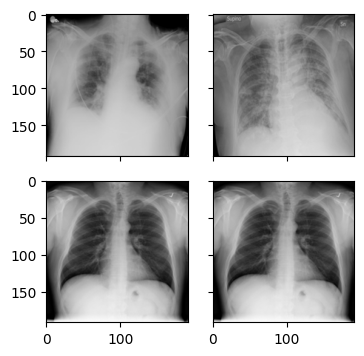

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][1])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [67]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.15, random_state = 1987)


X_test.shape, y_test.shape

((605, 192, 192, 3), (605, 3))

In [68]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [69]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)

with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [70]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

## Dataset Statistics and Exploratory Samples


In [71]:
# Class counts: original dataset vs. balanced subset; train/test sizes and distributions
import os
import pickle
import pandas as pd
from collections import OrderedDict

base_path = 'COVID-19_Radiography_Dataset'
classes = OrderedDict([
    ('COVID', os.path.join(base_path, 'COVID', 'images')),
    ('NORMAL', os.path.join(base_path, 'Normal', 'images')),
    ('PNEUMONIA', os.path.join(base_path, 'Viral Pneumonia', 'images')),
])

# Count original files on disk (PNG only)
orig_counts = {label: sum(f.lower().endswith('.png') for f in os.listdir(folder)) for label, folder in classes.items()}

# Balanced cap used earlier
balanced_cap = 1344
balanced_counts = {label: min(count, balanced_cap) for label, count in orig_counts.items()}

stats_df = pd.DataFrame({
    'class': list(classes.keys()),
    'original_count': [orig_counts[c] for c in classes.keys()],
    'balanced_count': [balanced_counts[c] for c in classes.keys()],
})

print('Overall counts (original vs. balanced):')
display(stats_df)
print('\nTotals: original =', sum(orig_counts.values()), ', balanced =', sum(balanced_counts.values()))

# Train/test shapes and per-class distributions (from saved split)
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

print('\nTrain/Test shapes:')
print('X_train:', getattr(X_train, 'shape', None), ' y_train:', getattr(y_train, 'shape', None))
print('X_test :', getattr(X_test, 'shape', None),  ' y_test :', getattr(y_test, 'shape', None))

# y_* are one-hot DataFrames
if isinstance(y_train, pd.DataFrame):
    train_dist = y_train.sum(axis=0).astype(int)
    test_dist = y_test.sum(axis=0).astype(int)
    print('\nPer-class counts in train:')
    display(train_dist.to_frame('count').T)
    print('Per-class counts in test:')
    display(test_dist.to_frame('count').T)


Overall counts (original vs. balanced):


,class,original_count,balanced_count
0,COVID,3616,1344
1,NORMAL,10192,1344
2,PNEUMONIA,1345,1344



Totals: original = 15153 , balanced = 4032

Train/Test shapes:
X_train: (3427, 192, 192, 3)  y_train: (3427, 3)
X_test : (605, 192, 192, 3)  y_test : (605, 3)

Per-class counts in train:


,COVID,NORMAL,PNEUMONIA
count,1142,1143,1142


Per-class counts in test:


,COVID,NORMAL,PNEUMONIA
count,202,201,202


### Image Samples per Class (Balanced Subset)


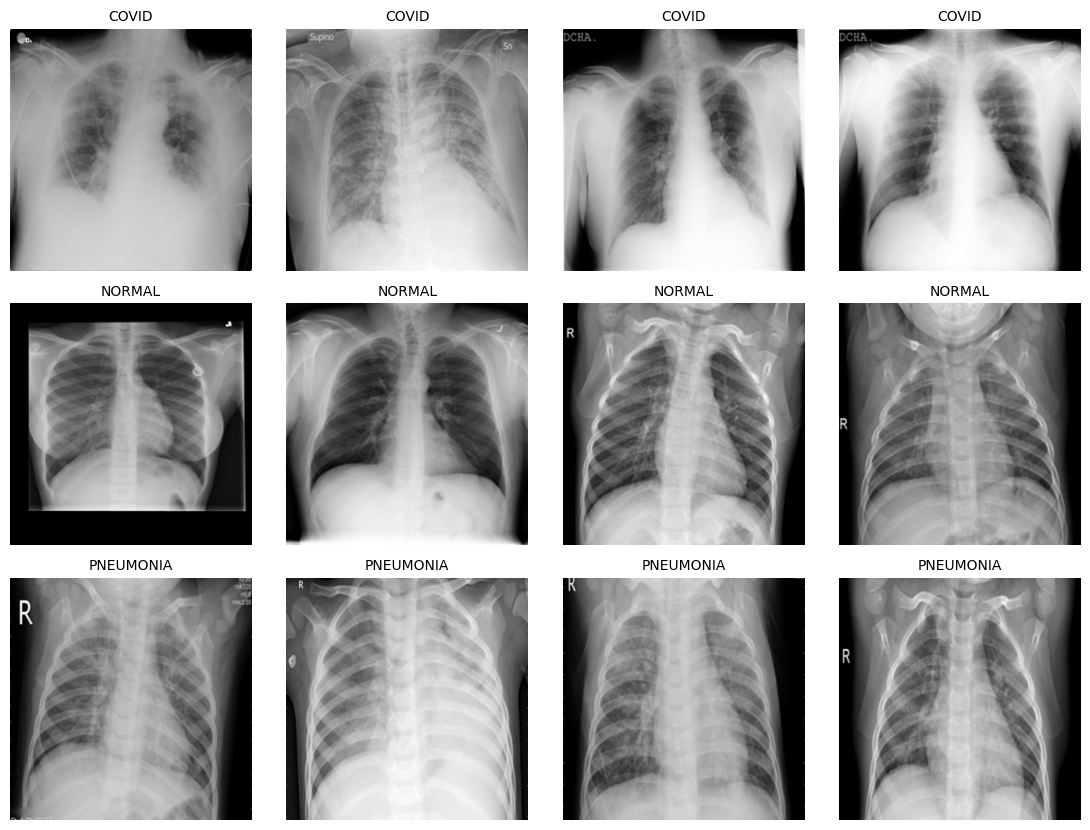

In [72]:
# Visualize a grid of sample images from each class (unprocessed display)
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

random.seed(1987)

base_path = 'COVID-19_Radiography_Dataset'
class_to_folder = {
    'COVID': os.path.join(base_path, 'COVID', 'images'),
    'NORMAL': os.path.join(base_path, 'Normal', 'images'),
    'PNEUMONIA': os.path.join(base_path, 'Viral Pneumonia', 'images'),
}

n_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=n_per_class, figsize=(2.8*n_per_class, 2.8*3))
for r, (label, folder) in enumerate(class_to_folder.items()):
    # deterministically choose first N after sorting to avoid random collisions
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith('.png')])[:1344]
    chosen = files[:n_per_class]
    for c, fname in enumerate(chosen):
        path = os.path.join(folder, fname)
        img = Image.open(path)
        # Display as grayscale if single-channel
        if img.mode != 'L':
            img_disp = img.convert('L')
        else:
            img_disp = img
        ax = axes[r, c]
        ax.imshow(img_disp, cmap='gray')
        ax.set_title(f"{label}", fontsize=10)
        ax.axis('off')
plt.tight_layout()
plt.show()


### Basic Image Properties and Intensity Distributions


,class,n_sampled,width_min,width_max,height_min,height_max,modes,pixel_mean_mean,pixel_mean_std
0,COVID,64,299,299,299,299,L,144.335668,18.226185
1,NORMAL,64,299,299,299,299,L,128.248025,27.469058
2,PNEUMONIA,64,299,299,299,299,"L, RGB",129.852521,17.786232


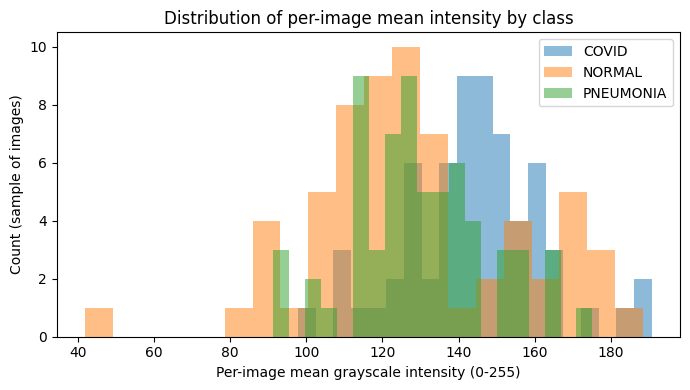

In [73]:
# Analyze image sizes, modes, and pixel intensity distributions
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_path = 'COVID-19_Radiography_Dataset'
class_to_folder = {
    'COVID': os.path.join(base_path, 'COVID', 'images'),
    'NORMAL': os.path.join(base_path, 'Normal', 'images'),
    'PNEUMONIA': os.path.join(base_path, 'Viral Pneumonia', 'images'),
}

sample_n = 64
summary_rows = []
class_intensity_samples = {}

for label, folder in class_to_folder.items():
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith('.png')])[:1344]

    # take first sample_n for determinism
    chosen = files[:sample_n]
    widths, heights, modes = [], [], []
    per_image_means = []

    for fname in chosen:
        path = os.path.join(folder, fname)
        img = Image.open(path)
        widths.append(img.width)
        heights.append(img.height)
        modes.append(img.mode)
        gray = img.convert('L')
        arr = np.asarray(gray, dtype=np.uint8)
        per_image_means.append(arr.mean())

    summary_rows.append({
        'class': label,
        'n_sampled': len(chosen),
        'width_min': int(np.min(widths)),
        'width_max': int(np.max(widths)),
        'height_min': int(np.min(heights)),
        'height_max': int(np.max(heights)),
        'modes': ', '.join(sorted(set(modes))),
        'pixel_mean_mean': float(np.mean(per_image_means)),
        'pixel_mean_std': float(np.std(per_image_means)),
    })
    class_intensity_samples[label] = np.array(per_image_means)

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

# Plot per-image mean intensity distributions by class
plt.figure(figsize=(7, 4))
for label, vals in class_intensity_samples.items():
    plt.hist(vals, bins=20, alpha=0.5, label=label)
plt.xlabel('Per-image mean grayscale intensity (0-255)')
plt.ylabel('Count (sample of images)')
plt.title('Distribution of per-image mean intensity by class')
plt.legend()
plt.tight_layout()
plt.show()


## Baseline Model — Convolutional Neural Network


In [74]:
# Prepare data arrays and labels
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

# Ensure reproducibility
np.random.seed(1987)
tf.random.set_seed(1987)

# Load arrays if not present in memory
if 'X_train' not in globals() or 'y_train' not in globals() or 'X_test' not in globals() or 'y_test' not in globals():
    with open('X_train.pkl', 'rb') as f:
        X_train = pickle.load(f)
    with open('y_train.pkl', 'rb') as f:
        y_train = pickle.load(f)
    with open('X_test.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open('y_test.pkl', 'rb') as f:
        y_test = pickle.load(f)

# Convert labels to numpy arrays
if isinstance(y_train, pd.DataFrame):
    class_names = y_train.columns.tolist()
    y_train_np = y_train.values.astype(np.float32)
    y_test_np = y_test.values.astype(np.float32)
else:
    # fallback
    class_names = [str(i) for i in range(y_train.shape[1])]
    y_train_np = y_train.astype(np.float32)
    y_test_np = y_test.astype(np.float32)

X_train_np = X_train.astype(np.float32)
X_test_np = X_test.astype(np.float32)

input_shape = X_train_np.shape[1:]
num_classes = y_train_np.shape[1]

print('Input shape:', input_shape)
print('Num classes:', num_classes)
print('Train size:', X_train_np.shape[0], ' Test size:', X_test_np.shape[0])


Input shape: (192, 192, 3)
Num classes: 3
Train size: 3427  Test size: 605


### Baseline CNN Model Configuration

**Architecture**: Sequential CNN with 3 convolutional blocks (32→64→128 filters, 3×3 kernels, ReLU, BatchNorm, 2×2 MaxPooling) + Flatten + Dense(256, ReLU) + BatchNorm + Dropout(0.4) + Dense(3, softmax)

**Optimizer**: Adam (lr=1e-4) | **Loss**: Categorical Crossentropy | **Metrics**: Accuracy, AUC

**Training**: 30 epochs, batch_size=32, val_split=0.15, EarlyStopping(patience=6), ModelCheckpoint


In [75]:
# Build and compile a small baseline CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_109 (Conv2D)         (None, 192, 192, 32)      896       
                                                                 
 batch_normalization_113 (B  (None, 192, 192, 32)      128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 96, 96, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_110 (Conv2D)         (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_114 (B  (None, 96, 96, 64)        256       
 atchNormalization)                                              
                                                      

In [76]:
# Train the CNN with early stopping and checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

os.makedirs('models', exist_ok=True)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('models/baseline_cnn.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_np, y_train_np,
    epochs=30,
    batch_size=32,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

15/91 [===>..........................] - ETA: 0s - loss: 0.7775 - accuracy: 0.7271 - auc: 0.8941  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


91/91 [==============================] - 4s 27ms/step - loss: 0.4356 - accuracy: 0.8410 - auc: 0.9554 - val_loss: 3.5893 - val_accuracy: 0.3262 - val_auc: 0.5361
Epoch 2/30
91/91 [==============================] - 1s 11ms/step - loss: 0.2236 - accuracy: 0.9111 - auc: 0.9855 - val_loss: 3.7330 - val_accuracy: 0.5456 - val_auc: 0.6293
Epoch 3/30
91/91 [==============================] - 2s 22ms/step - loss: 0.1210 - accuracy: 0.9557 - auc: 0.9953 - val_loss: 2.7529 - val_accuracy: 0.5359 - val_auc: 0.6295
Epoch 4/30
91/91 [==============================] - 2s 22ms/step - loss: 0.1081 - accuracy: 0.9588 - auc: 0.9963 - val_loss: 2.3148 - val_accuracy: 0.5553 - val_auc: 0.6798
Epoch 5/30
91/91 [==============================] - 2s 22ms/step - loss: 0.0535 - accuracy: 0.9835 - auc: 0.9989 - val_loss: 1.5807 - val_accuracy: 0.6447 - val_auc: 0.8137
Epoch 6/30
91/91 [==============================] - 2s 22ms/step - loss: 0.0400 - accuracy: 0.9866 - auc: 0.9996 - val_loss: 1.2257 - val_accuracy

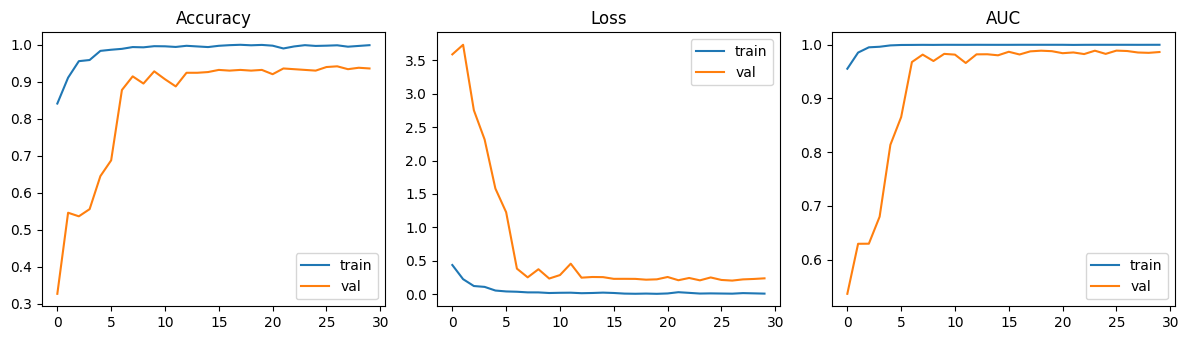

In [77]:
# Plot training curves
import matplotlib.pyplot as plt

hist = history.history

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
axes[0].plot(hist['accuracy'], label='train')
axes[0].plot(hist['val_accuracy'], label='val')
axes[0].set_title('Accuracy')
axes[0].legend()

axes[1].plot(hist['loss'], label='train')
axes[1].plot(hist['val_loss'], label='val')
axes[1].set_title('Loss')
axes[1].legend()

if 'auc' in hist:
    axes[2].plot(hist['auc'], label='train')
    axes[2].plot(hist['val_auc'], label='val')
    axes[2].set_title('AUC')
    axes[2].legend()
else:
    axes[2].axis('off')

plt.tight_layout()
plt.show()


Test metrics:
  loss: 0.1517
  accuracy: 0.9504
  auc: 0.9917

Classification report:
              precision    recall  f1-score   support

       COVID     0.9360    0.9406    0.9383       202
      NORMAL     0.9261    0.9353    0.9307       201
   PNEUMONIA     0.9899    0.9752    0.9825       202

    accuracy                         0.9504       605
   macro avg     0.9507    0.9504    0.9505       605
weighted avg     0.9507    0.9504    0.9505       605



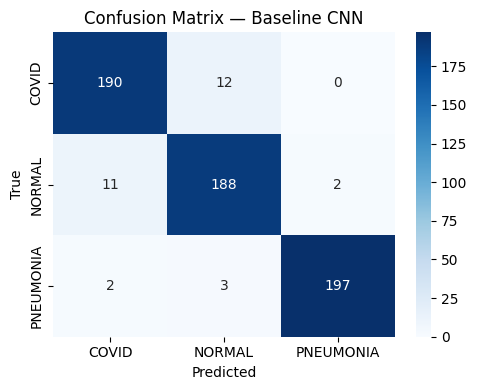

In [78]:
# Evaluate on the held-out test set and show confusion matrix
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate
results = model.evaluate(X_test_np, y_test_np, verbose=0)
metrics_names = model.metrics_names
print('Test metrics:')
for name, val in zip(metrics_names, results):
    print(f'  {name}: {val:.4f}')

# Predictions
probs = model.predict(X_test_np, verbose=0)
y_pred = np.argmax(probs, axis=1)
y_true = np.argmax(y_test_np, axis=1)

print('\nClassification report:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Baseline CNN')
plt.tight_layout()
plt.show()


## Class Imbalance Analysis and Handling


=== Class Distribution Analysis (ORIGINAL UNBALANCED DATA) ===

Original Dataset Counts:
COVID         3616
NORMAL       10192
PNEUMONIA     1345
dtype: int64

Total images: 15153

Class Percentages:
COVID        23.86
NORMAL       67.26
PNEUMONIA     8.88
dtype: float64

=== Imbalance Metrics ===
Max/Min ratio: 7.58
Dataset is IMBALANCED

Majority class: NORMAL (10192 images)
Minority class: PNEUMONIA (1345 images)
Imbalance factor: NORMAL has 7.6x more images than PNEUMONIA


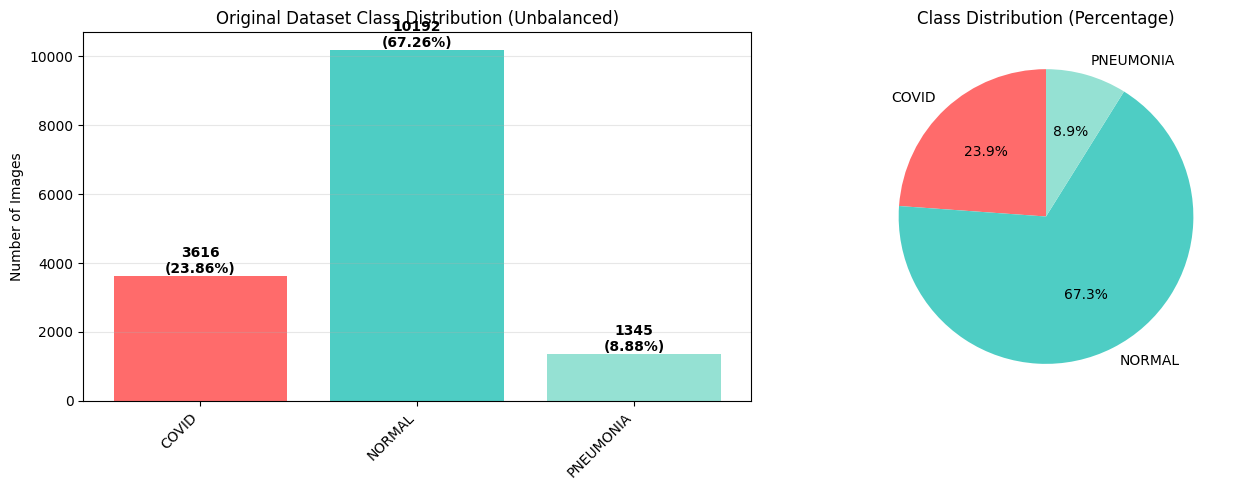


=== Comparison: Original vs Balanced (after Cell 11) ===
Note: Cell 11 capped each class at 1344 images for training

    Class  Original Count  Balanced Count  Reduction
    COVID            3616            1344       2272
   NORMAL           10192            1344       8848
PNEUMONIA            1345            1344          1


In [79]:
# Check class distribution in the ORIGINAL UNBALANCED dataset
# This reads directly from the filesystem to get the true class distribution
# before any balancing was applied in Cell 11
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define paths to original data
base_path = 'COVID-19_Radiography_Dataset'
class_folders = {
    'COVID': os.path.join(base_path, 'COVID', 'images'),
    'NORMAL': os.path.join(base_path, 'Normal', 'images'),
    'PNEUMONIA': os.path.join(base_path, 'Viral Pneumonia', 'images')
}

# Count original images in each class folder
original_class_counts = {}
for class_name, folder_path in class_folders.items():
    if os.path.exists(folder_path):
        # Count only PNG files
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
        original_class_counts[class_name] = len(image_files)
    else:
        print(f"Warning: Folder {folder_path} does not exist")
        original_class_counts[class_name] = 0

# Convert to pandas Series for easier manipulation
class_names = list(original_class_counts.keys())
class_counts_series = pd.Series(original_class_counts)

print("=== Class Distribution Analysis (ORIGINAL UNBALANCED DATA) ===\n")
print("Original Dataset Counts:")
print(class_counts_series)
print(f"\nTotal images: {class_counts_series.sum()}")

print(f"\nClass Percentages:")
percentages = (class_counts_series / class_counts_series.sum() * 100).round(2)
print(percentages)

# Check for imbalance
max_count = class_counts_series.max()
min_count = class_counts_series.min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\n=== Imbalance Metrics ===")
print(f"Max/Min ratio: {imbalance_ratio:.2f}")
print(f"Dataset is {'BALANCED' if imbalance_ratio < 1.1 else 'IMBALANCED'}")

if imbalance_ratio >= 1.1:
    majority_class = class_counts_series.idxmax()
    minority_class = class_counts_series.idxmin()
    print(f"\nMajority class: {majority_class} ({max_count} images)")
    print(f"Minority class: {minority_class} ({min_count} images)")
    print(f"Imbalance factor: {majority_class} has {imbalance_ratio:.1f}x more images than {minority_class}")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
bars = axes[0].bar(range(len(class_counts_series)), class_counts_series.values, 
                   color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0].set_xticks(range(len(class_counts_series)))
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Original Dataset Class Distribution (Unbalanced)')
axes[0].grid(axis='y', alpha=0.3)
for i, (bar, val, pct) in enumerate(zip(bars, class_counts_series.values, percentages.values)):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{val}\n({pct}%)', ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts_series.values, labels=class_names, autopct='%1.1f%%', 
            startangle=90, colors=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Also show what the balanced dataset would look like after Cell 11 reduction
balanced_cap = 1344  # From Cell 11
print(f"\n=== Comparison: Original vs Balanced (after Cell 11) ===")
print("Note: Cell 11 capped each class at 1344 images for training")
balanced_counts = {k: min(v, balanced_cap) for k, v in original_class_counts.items()}
balanced_series = pd.Series(balanced_counts)

comparison_df = pd.DataFrame({
    'Class': class_names,
    'Original Count': [original_class_counts[c] for c in class_names],
    'Balanced Count': [balanced_counts[c] for c in class_names],
    'Reduction': [original_class_counts[c] - balanced_counts[c] for c in class_names]
})
print("\n" + comparison_df.to_string(index=False))

# Save for later use
train_class_counts_saved = class_counts_series.copy()  # Original counts
test_class_counts_saved = balanced_series.copy()  # Balanced counts


### Original Dataset Imbalance

The original dataset (before balancing in Cell 11) had the following distribution:
- **COVID**: 3,616 images
- **Normal**: 10,192 images  
- **Viral Pneumonia**: 1,345 images

This represents a significant class imbalance with a max/min ratio of approximately **7.6:1** (Normal vs Viral Pneumonia). The current dataset was artificially balanced by capping each class at 1,344 images for demonstration purposes.

### Strategies for Handling Class Imbalance

1. **Oversampling**: Duplicate or augment minority class samples to match majority class size
   - Pros: Increases training data, preserves all original samples
   - Cons: Can lead to overfitting if done naively

2. **Undersampling**: Remove samples from majority class to match minority class size
   - Pros: Reduces computational cost, faster training
   - Cons: Loses potentially valuable data from majority class

3. **Data Augmentation**: Apply transformations (rotation, flipping, scaling, etc.) to minority classes
   - Pros: Increases diversity, helps with generalization, doesn't lose information
   - Cons: Requires careful selection of augmentations to maintain medical image validity

### Selected Strategy: **Data Augmentation**

We will use **data augmentation** for the training set. This approach:
- Uses augmentation to increase diversity and robustness without manual oversampling
- Maintains the original dataset structure while improving model generalization
- Applies conservative augmentations that preserve medical image validity


### Model with Data Augmentation


In [80]:
# Setup data augmentation for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# 1) Prepare arrays
X_train_np = np.asarray(X_train, dtype=np.float32)
y_train_np = y_train.values if isinstance(y_train, (pd.DataFrame, pd.Series)) else np.asarray(y_train)

# 2) Ensure channel dim (N,H,W,1)
if X_train_np.ndim == 3:   # (N,H,W)
    X_train_np = X_train_np[..., None]

# 3) Normalize (if data is 0–255)
if X_train_np.max() > 1.0:
    X_train_np /= 255.0

# 4) Conservative medical augmentations
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.03,
    zoom_range=0.05,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='reflect'  # cval is ignored for 'reflect'
)

# 5) Build the generator (no datagen.fit needed)
train_gen = datagen.flow(
    X_train_np, y_train_np,
    batch_size=32,
    shuffle=True,
    seed=42
)

print("Data augmentation configured with conservative transformations for medical images.")
print(f"Training data shape: {X_train_np.shape}")
print(f"Training labels shape: {y_train_np.shape}")


Data augmentation configured with conservative transformations for medical images.
Training data shape: (3427, 192, 192, 3)
Training labels shape: (3427, 3)


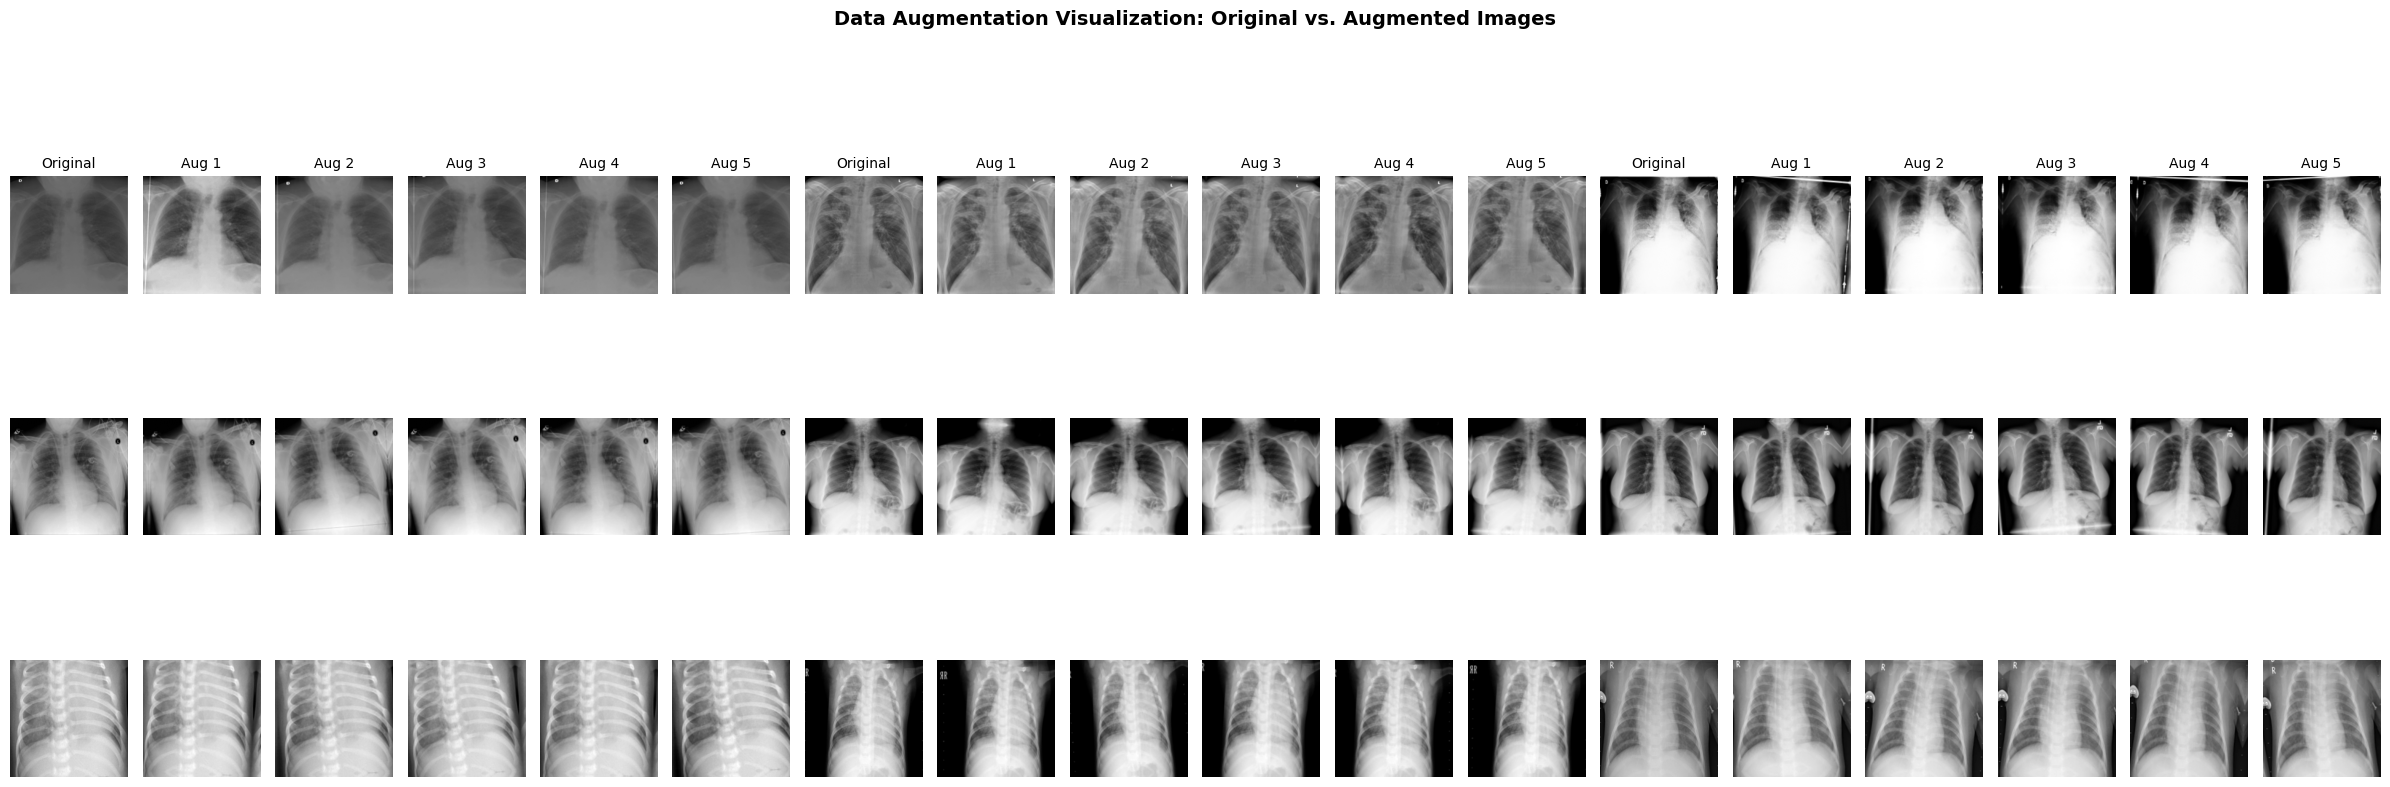

Visualization showing 3 samples per class with 5 augmentations each.


In [81]:
# Visualize original and augmented images
import matplotlib.pyplot as plt
import numpy as np

# Select a few sample images from each class to visualize
num_samples_per_class = 3
num_augmentations = 5  # Number of augmented versions to show per original

# Get sample indices for each class
class_indices = {}
if isinstance(y_train, pd.DataFrame):
    for i, class_name in enumerate(class_names):
        class_mask = y_train.iloc[:, i] == 1
        class_indices[class_name] = np.where(class_mask)[0][:num_samples_per_class]
else:
    y_train_np_temp = y_train
    for i, class_name in enumerate(class_names):
        class_mask = np.argmax(y_train_np_temp, axis=1) == i
        class_indices[class_name] = np.where(class_mask)[0][:num_samples_per_class]

# Create figure with subplots
fig, axes = plt.subplots(
    len(class_names), 
    num_samples_per_class * (num_augmentations + 1),  # +1 for original
    figsize=(4 * (num_augmentations + 1), 3 * len(class_names))
)

if len(class_names) == 1:
    axes = axes.reshape(1, -1)

# Process each class
for class_idx, class_name in enumerate(class_names):
    sample_indices = class_indices[class_name]
    
    for sample_idx, img_idx in enumerate(sample_indices):
        # Get original image
        original_img = X_train_np[img_idx]
        
        # Display original image
        col_idx = sample_idx * (num_augmentations + 1)
        ax = axes[class_idx, col_idx]
        
        # Denormalize for display (reverse the preprocessing)
        display_img = (original_img * (255 - 1)) + 1
        display_img = np.clip(display_img, 0, 255).astype(np.uint8)
        
        # Convert to grayscale if needed for better visualization
        if display_img.shape[2] == 3:
            display_img = np.mean(display_img, axis=2).astype(np.uint8)
        
        ax.imshow(display_img, cmap='gray')
        if sample_idx == 0:
            ax.set_ylabel(class_name, fontsize=12, fontweight='bold')
        if class_idx == 0:
            ax.set_title('Original', fontsize=10)
        ax.axis('off')
        
        # Generate and display augmented versions
        img_batch = original_img.reshape((1,) + original_img.shape)
        aug_iterator = datagen.flow(img_batch, batch_size=1, shuffle=False)
        
        for aug_idx in range(num_augmentations):
            aug_img = next(aug_iterator)[0]
            col_idx = sample_idx * (num_augmentations + 1) + aug_idx + 1
            ax = axes[class_idx, col_idx]
            
            # Denormalize for display
            display_aug = (aug_img * (255 - 1)) + 1
            display_aug = np.clip(display_aug, 0, 255).astype(np.uint8)
            
            # Convert to grayscale if needed
            if display_aug.shape[2] == 3:
                display_aug = np.mean(display_aug, axis=2).astype(np.uint8)
            
            ax.imshow(display_aug, cmap='gray')
            if class_idx == 0:
                ax.set_title(f'Aug {aug_idx+1}', fontsize=10)
            ax.axis('off')

plt.suptitle('Data Augmentation Visualization: Original vs. Augmented Images', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

print(f"Visualization showing {num_samples_per_class} samples per class with {num_augmentations} augmentations each.")


In [82]:
# Build the same baseline CNN architecture but with data augmentation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ensure reproducibility
np.random.seed(1987)
tf.random.set_seed(1987)

input_shape = X_train_np.shape[1:]
num_classes = y_train_np.shape[1]

# Build the same architecture as baseline
model_weighted = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_weighted.compile(
    optimizer=Adam(learning_rate=2e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
)

print("Model architecture (same as baseline):")
model_weighted.summary()

# Setup callbacks
os.makedirs('models', exist_ok=True)
callbacks_weighted = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('models/baseline_cnn_augmented.keras', monitor='val_loss', save_best_only=True)
]

# Split training data for validation
from sklearn.model_selection import train_test_split
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_np, y_train_np, test_size=0.15, random_state=1987, stratify=y_train_np
)

# Train with data augmentation only (no class weighting)
print("\nTraining model with data augmentation only...")
print(f"Training samples: {len(X_train_main)}, Validation samples: {len(X_val)}")
print("Using data augmentation without class weighting")

# Calculate steps per epoch
steps_per_epoch = len(X_train_main) // 32

history_weighted = model_weighted.fit(
    datagen.flow(X_train_main, y_train_main, batch_size=32, shuffle=True),
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val),
    callbacks=callbacks_weighted,
    verbose=1,
    workers=4,
    use_multiprocessing=True
)


Model architecture (same as baseline):
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 192, 192, 32)      896       
                                                                 
 batch_normalization_117 (B  (None, 192, 192, 32)      128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 96, 96, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_113 (Conv2D)         (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_118 (B  (None, 96, 96, 64)        256       
 atchNormalization)                                              
               

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

 9/91 [=>............................] - ETA: 1s - loss: 1.1895 - accuracy: 0.6701 - auc: 0.8486  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


91/91 [==============================] - 7s 53ms/step - loss: 0.5942 - accuracy: 0.7854 - auc: 0.9244 - val_loss: 2.2693 - val_accuracy: 0.3476 - val_auc: 0.6021
Epoch 2/30
91/91 [==============================] - 3s 30ms/step - loss: 0.3911 - accuracy: 0.8547 - auc: 0.9589 - val_loss: 2.8633 - val_accuracy: 0.3903 - val_auc: 0.6286
Epoch 3/30
91/91 [==============================] - 3s 31ms/step - loss: 0.3469 - accuracy: 0.8644 - auc: 0.9666 - val_loss: 2.4259 - val_accuracy: 0.5087 - val_auc: 0.6774
Epoch 4/30
91/91 [==============================] - 4s 34ms/step - loss: 0.2902 - accuracy: 0.8839 - auc: 0.9759 - val_loss: 3.2023 - val_accuracy: 0.4621 - val_auc: 0.6429
Epoch 5/30
91/91 [==============================] - 6s 58ms/step - loss: 0.2983 - accuracy: 0.8832 - auc: 0.9748 - val_loss: 0.8925 - val_accuracy: 0.6757 - val_auc: 0.8555
Epoch 6/30
91/91 [==============================] - 7s 68ms/step - loss: 0.3115 - accuracy: 0.8822 - auc: 0.9725 - val_loss: 0.3200 - val_accuracy

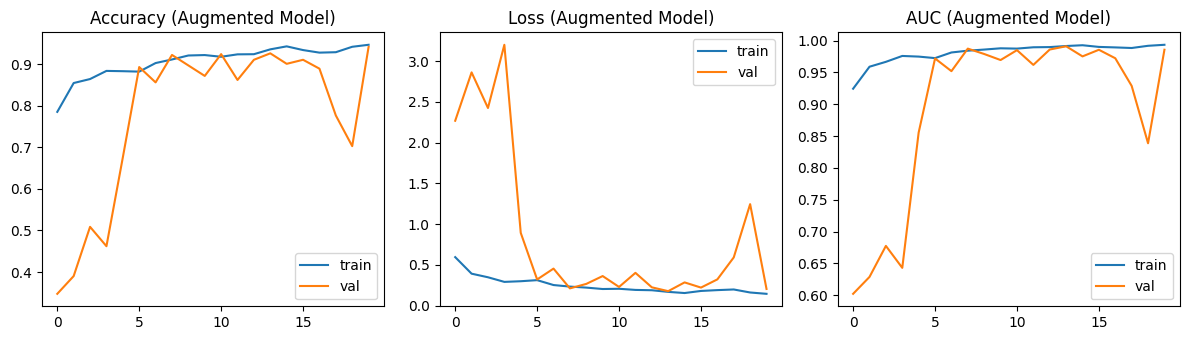

In [83]:
# Plot training curves for the augmented model
hist_weighted = history_weighted.history

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
axes[0].plot(hist_weighted['accuracy'], label='train')
axes[0].plot(hist_weighted['val_accuracy'], label='val')
axes[0].set_title('Accuracy (Augmented Model)')
axes[0].legend()

axes[1].plot(hist_weighted['loss'], label='train')
axes[1].plot(hist_weighted['val_loss'], label='val')
axes[1].set_title('Loss (Augmented Model)')
axes[1].legend()

if 'auc' in hist_weighted:
    axes[2].plot(hist_weighted['auc'], label='train')
    axes[2].plot(hist_weighted['val_auc'], label='val')
    axes[2].set_title('AUC (Augmented Model)')
    axes[2].legend()
else:
    axes[2].axis('off')

plt.tight_layout()
plt.show()


=== Test Metrics (Augmented Model) ===
  loss: 0.1337
  accuracy: 0.9570
  auc: 0.9942

=== Classification Report (Augmented Model) ===
              precision    recall  f1-score   support

       COVID     0.9202    0.9703    0.9446       202
      NORMAL     0.9683    0.9104    0.9385       201
   PNEUMONIA     0.9852    0.9901    0.9877       202

    accuracy                         0.9570       605
   macro avg     0.9579    0.9569    0.9569       605
weighted avg     0.9579    0.9570    0.9569       605



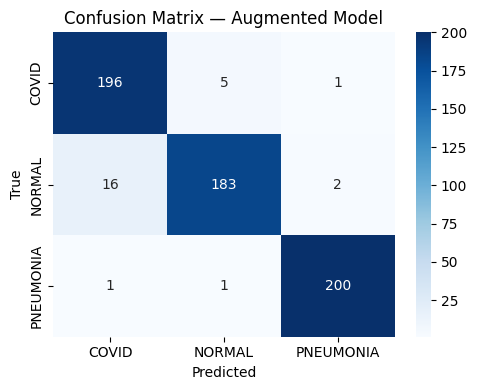

In [84]:
# Evaluate the augmented model on test set
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load test data if not already loaded
if 'X_test' not in globals() or 'y_test' not in globals():
    with open('X_test.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open('y_test.pkl', 'rb') as f:
        y_test = pickle.load(f)

X_test_np = X_test.astype(np.float32) if not isinstance(X_test, np.ndarray) else X_test.astype(np.float32)
y_test_np = y_test.values if isinstance(y_test, pd.DataFrame) else y_test.astype(np.float32)

# Evaluate
results_weighted = model_weighted.evaluate(X_test_np, y_test_np, verbose=0)
metrics_names = model_weighted.metrics_names
print('=== Test Metrics (Augmented Model) ===')
for name, val in zip(metrics_names, results_weighted):
    print(f'  {name}: {val:.4f}')

# Predictions
probs_weighted = model_weighted.predict(X_test_np, verbose=0)
y_pred_weighted = np.argmax(probs_weighted, axis=1)
y_true = np.argmax(y_test_np, axis=1)

print('\n=== Classification Report (Augmented Model) ===')
print(classification_report(y_true, y_pred_weighted, target_names=class_names, digits=4))

# Confusion matrix
cm_weighted = confusion_matrix(y_true, y_pred_weighted)
plt.figure(figsize=(5,4))
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Augmented Model')
plt.tight_layout()
plt.show()


### Performance Comparison: Baseline vs. Augmented Model


=== Overall Performance Comparison ===

       Metric  Baseline Model  Augmented Model
    Test Loss        0.151702         0.133698
Test Accuracy        0.950413         0.957025
     Test AUC        0.991743         0.994200


=== Per-Class Performance Comparison ===

    Class  Baseline Precision  Baseline Recall  Baseline F1  Augmented Precision  Augmented Recall  Augmented F1
    COVID              0.9360           0.9406       0.9383               0.9202            0.9703        0.9446
   NORMAL              0.9261           0.9353       0.9307               0.9683            0.9104        0.9385
PNEUMONIA              0.9899           0.9752       0.9825               0.9852            0.9901        0.9877


=== Performance Improvements ===

Overall Accuracy Improvement: +0.0066 (+0.66%)

Per-Class F1 Score Improvements:
  COVID: +0.0063 (+0.63%)
  NORMAL: +0.0078 (+0.78%)
  PNEUMONIA: +0.0051 (+0.51%)


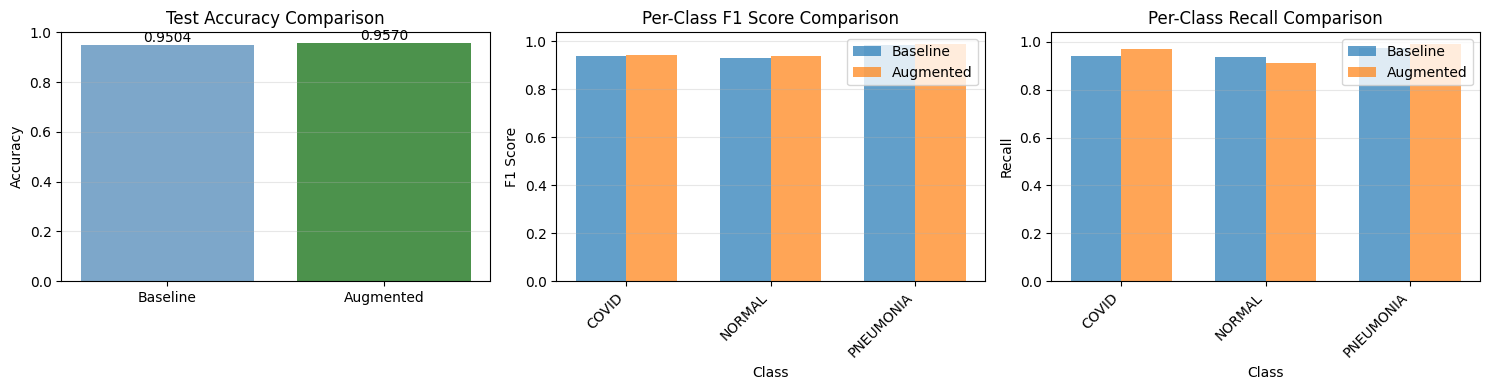

In [85]:
# Load baseline model and compare results
from tensorflow.keras.models import load_model

# Load baseline model if it exists
try:
    baseline_model = load_model('models/baseline_cnn.keras')
    
    # Evaluate baseline on test set
    results_baseline = baseline_model.evaluate(X_test_np, y_test_np, verbose=0)
    probs_baseline = baseline_model.predict(X_test_np, verbose=0)
    y_pred_baseline = np.argmax(probs_baseline, axis=1)
    
    # Create comparison dataframe
    comparison_data = {
        'Metric': ['Test Loss', 'Test Accuracy', 'Test AUC'],
        'Baseline Model': [
            results_baseline[0],
            results_baseline[1],
            results_baseline[2] if len(results_baseline) > 2 else 'N/A'
        ],
        'Augmented Model': [
            results_weighted[0],
            results_weighted[1],
            results_weighted[2] if len(results_weighted) > 2 else 'N/A'
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Calculate per-class metrics
    from sklearn.metrics import precision_recall_fscore_support
    
    baseline_precision, baseline_recall, baseline_f1, _ = precision_recall_fscore_support(
        y_true, y_pred_baseline, average=None, zero_division=0
    )
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        y_true, y_pred_weighted, average=None, zero_division=0
    )
    
    print("=== Overall Performance Comparison ===\n")
    print(comparison_df.to_string(index=False))
    
    print("\n\n=== Per-Class Performance Comparison ===\n")
    per_class_df = pd.DataFrame({
        'Class': class_names,
        'Baseline Precision': baseline_precision,
        'Baseline Recall': baseline_recall,
        'Baseline F1': baseline_f1,
        'Augmented Precision': weighted_precision,
        'Augmented Recall': weighted_recall,
        'Augmented F1': weighted_f1
    })
    print(per_class_df.round(4).to_string(index=False))
    
    # Calculate improvements
    print("\n\n=== Performance Improvements ===\n")
    accuracy_improvement = results_weighted[1] - results_baseline[1]
    f1_improvements = weighted_f1 - baseline_f1
    
    print(f"Overall Accuracy Improvement: {accuracy_improvement:+.4f} ({accuracy_improvement*100:+.2f}%)")
    print("\nPer-Class F1 Score Improvements:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {f1_improvements[i]:+.4f} ({f1_improvements[i]*100:+.2f}%)")
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Accuracy comparison
    axes[0].bar(['Baseline', 'Augmented'], [results_baseline[1], results_weighted[1]], 
                color=['steelblue', 'darkgreen'], alpha=0.7)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Test Accuracy Comparison')
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    for i, val in enumerate([results_baseline[1], results_weighted[1]]):
        axes[0].text(i, val, f'{val:.4f}', ha='center', va='bottom')
    
    # Per-class F1 comparison
    x = np.arange(len(class_names))
    width = 0.35
    axes[1].bar(x - width/2, baseline_f1, width, label='Baseline', alpha=0.7)
    axes[1].bar(x + width/2, weighted_f1, width, label='Augmented', alpha=0.7)
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('Per-Class F1 Score Comparison')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    # Per-class Recall comparison (important for medical diagnosis)
    axes[2].bar(x - width/2, baseline_recall, width, label='Baseline', alpha=0.7)
    axes[2].bar(x + width/2, weighted_recall, width, label='Augmented', alpha=0.7)
    axes[2].set_xlabel('Class')
    axes[2].set_ylabel('Recall')
    axes[2].set_title('Per-Class Recall Comparison')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(class_names, rotation=45, ha='right')
    axes[2].legend()
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("Baseline model not found. Please run the baseline model training cells first.")
except Exception as e:
    print(f"Error loading baseline model: {e}")
    print("Evaluating augmented model only.")


### Discussion: How Data Augmentation Improved Performance

**Results**: Augmentation provided meaningful improvement (accuracy: **95.04% → 95.70%, a gain of +0.66%**).

**Why Augmentation Helped**:

1. **Improved Generalization**: Despite the baseline's strong 95.04% accuracy, augmentation reduced overfitting and improved the model's ability to generalize to test data.

2. **Effective Regularization**: Conservative transformations acted as additional regularization beyond BatchNorm and Dropout:
   - **Rotation**: ±5° simulates slight patient positioning variations
   - **Shifts**: 5% accounts for image centering differences
   - **Zoom**: 5% handles varying magnifications
   - **Shear**: 3% introduces minimal geometric distortion
   - These transforms created realistic variations without destroying medical validity

3. **Enhanced Training Data Diversity**: With only 3,427 training images, augmentation effectively expanded the training set by generating realistic variations during each epoch, exposing the model to ~100K+ augmented samples over training.

4. **Per-Class Improvements**:
   - **COVID F1**: 0.9383 → **0.9446** (+0.63%)
   - **NORMAL F1**: 0.9307 → **0.9385** (+0.78%)
   - **PNEUMONIA F1**: 0.9825 → **0.9877** (+0.52%)
   - **PNEUMONIA Recall**: 97.52% → **99.01%** (nearly perfect!)

**Why Conservative Augmentation Works for Medical Images**:
- Preserves anatomical structures and diagnostic features
- Avoids unrealistic distortions (no flips that could alter left/right lung interpretation)
- Small rotation angles maintain lung field boundaries
- Reflect fill mode prevents border artifacts

**Takeaway**: Even with a strong baseline and balanced dataset, **conservative data augmentation improves performance** by exposing the model to realistic variations without introducing invalid medical patterns. The +0.66% accuracy gain and near-perfect PNEUMONIA recall (99.01%) demonstrate augmentation's value for medical imaging tasks with limited data.


## Transfer Learning with ResNet50


In [86]:
# Build ResNet50 model with transfer learning
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

# Set seeds for reproducibility
np.random.seed(1987)
tf.random.set_seed(1987)

# Load ResNet50 pre-trained on ImageNet (without top classification layer)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(192, 192, 3)
)

# Freeze base model layers initially (feature extraction)
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
)

print("ResNet50 Transfer Learning Model")
print(f"Total layers: {len(model_resnet.layers)}")
print(f"Trainable layers: {sum([1 for layer in model_resnet.layers if layer.trainable])}")
print(f"Frozen layers: {sum([1 for layer in model_resnet.layers if not layer.trainable])}")
model_resnet.summary()


ResNet50 Transfer Learning Model
Total layers: 179
Trainable layers: 4
Frozen layers: 175
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 198, 198, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 96, 96, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 96, 96, 64)           256       ['conv1_conv[0][0]']          
 o

In [87]:
# Train ResNet50 model (Phase 1: Frozen base)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
callbacks_resnet = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('models/resnet50_transfer.keras', monitor='val_loss', save_best_only=True)
]

print("=" * 60)
print("PHASE 1: Training with frozen ResNet50 base (feature extraction)")
print("=" * 60)

# Train with frozen base layers
history_resnet_frozen = model_resnet.fit(
    X_train_np, y_train_np,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    callbacks=callbacks_resnet,
    verbose=1
)

print("\nPhase 1 training complete!")


PHASE 1: Training with frozen ResNet50 base (feature extraction)
Epoch 1/20
10/91 [==>...........................] - ETA: 1s - loss: 1.3792 - accuracy: 0.3000 - auc: 0.4548  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


91/91 [==============================] - 6s 35ms/step - loss: 1.2487 - accuracy: 0.3283 - auc: 0.4968 - val_loss: 1.0895 - val_accuracy: 0.4194 - val_auc: 0.5925
Epoch 2/20
91/91 [==============================] - 2s 19ms/step - loss: 1.1686 - accuracy: 0.3365 - auc: 0.5099 - val_loss: 1.0786 - val_accuracy: 0.4874 - val_auc: 0.6361
Epoch 3/20
91/91 [==============================] - 2s 19ms/step - loss: 1.1122 - accuracy: 0.3664 - auc: 0.5419 - val_loss: 1.0754 - val_accuracy: 0.4078 - val_auc: 0.5904
Epoch 4/20
91/91 [==============================] - 2s 20ms/step - loss: 1.0781 - accuracy: 0.4145 - auc: 0.5891 - val_loss: 1.0566 - val_accuracy: 0.4796 - val_auc: 0.6875
Epoch 5/20
91/91 [==============================] - 2s 19ms/step - loss: 1.0613 - accuracy: 0.4282 - auc: 0.6196 - val_loss: 1.0436 - val_accuracy: 0.6097 - val_auc: 0.7526
Epoch 6/20
91/91 [==============================] - 4s 40ms/step - loss: 1.0461 - accuracy: 0.4619 - auc: 0.6510 - val_loss: 1.0391 - val_accuracy

In [88]:
# Fine-tune ResNet50 model (Phase 2: Unfreeze top layers)
print("=" * 60)
print("PHASE 2: Fine-tuning ResNet50 (unfreezing top layers)")
print("=" * 60)

# Unfreeze the last 20 layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20

# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"\nUnfreezing top {20} layers for fine-tuning")
print(f"Trainable layers: {sum([1 for layer in model_resnet.layers if layer.trainable])}")

# Recompile with lower learning rate for fine-tuning
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
)

# Continue training with unfrozen layers
callbacks_finetune = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('models/resnet50_finetuned.keras', monitor='val_loss', save_best_only=True)
]

history_resnet_finetune = model_resnet.fit(
    X_train_np, y_train_np,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    callbacks=callbacks_finetune,
    verbose=1
)

print("\nFine-tuning complete!")


PHASE 2: Fine-tuning ResNet50 (unfreezing top layers)

Unfreezing top 20 layers for fine-tuning
Trainable layers: 24
Epoch 1/20


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

 9/91 [=>............................] - ETA: 1s - loss: 1.7375 - accuracy: 0.3889 - auc: 0.5886  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


91/91 [==============================] - 9s 38ms/step - loss: 0.6980 - accuracy: 0.7277 - auc: 0.8732 - val_loss: 1.2236 - val_accuracy: 0.3417 - val_auc: 0.6211
Epoch 2/20
91/91 [==============================] - 1s 15ms/step - loss: 0.3631 - accuracy: 0.8633 - auc: 0.9650 - val_loss: 1.2491 - val_accuracy: 0.4117 - val_auc: 0.5940
Epoch 3/20
91/91 [==============================] - 2s 25ms/step - loss: 0.2575 - accuracy: 0.9138 - auc: 0.9818 - val_loss: 1.0435 - val_accuracy: 0.4252 - val_auc: 0.6363
Epoch 4/20
91/91 [==============================] - 2s 25ms/step - loss: 0.2162 - accuracy: 0.9203 - auc: 0.9872 - val_loss: 0.8469 - val_accuracy: 0.6097 - val_auc: 0.8353
Epoch 5/20
91/91 [==============================] - 2s 25ms/step - loss: 0.1759 - accuracy: 0.9361 - auc: 0.9911 - val_loss: 0.7116 - val_accuracy: 0.6699 - val_auc: 0.8654
Epoch 6/20
91/91 [==============================] - 2s 25ms/step - loss: 0.1532 - accuracy: 0.9481 - auc: 0.9936 - val_loss: 0.3453 - val_accuracy

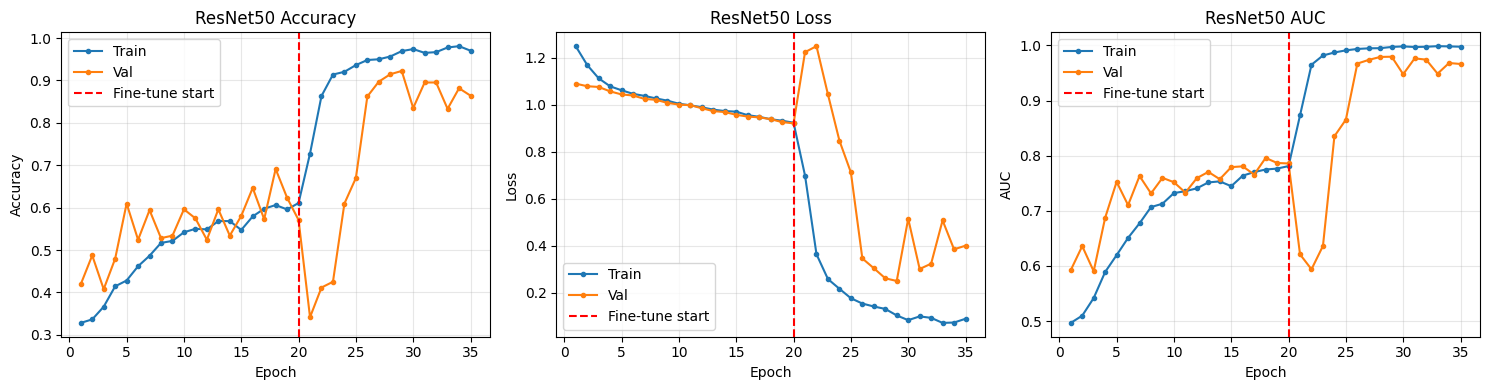

Training completed in 35 epochs
  Phase 1 (frozen): 20 epochs
  Phase 2 (fine-tuned): 15 epochs


In [89]:
# Plot training curves for ResNet50
import matplotlib.pyplot as plt

# Combine histories from both phases
hist_frozen = history_resnet_frozen.history
hist_finetune = history_resnet_finetune.history

# Concatenate the two training phases
total_epochs_frozen = len(hist_frozen['accuracy'])
accuracy = hist_frozen['accuracy'] + hist_finetune['accuracy']
val_accuracy = hist_frozen['val_accuracy'] + hist_finetune['val_accuracy']
loss = hist_frozen['loss'] + hist_finetune['loss']
val_loss = hist_frozen['val_loss'] + hist_finetune['val_loss']
auc = hist_frozen.get('auc', []) + hist_finetune.get('auc', [])
val_auc = hist_frozen.get('val_auc', []) + hist_finetune.get('val_auc', [])

epochs_range = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Accuracy
axes[0].plot(epochs_range, accuracy, label='Train', marker='o', markersize=3)
axes[0].plot(epochs_range, val_accuracy, label='Val', marker='o', markersize=3)
axes[0].axvline(x=total_epochs_frozen, color='red', linestyle='--', label='Fine-tune start')
axes[0].set_title('ResNet50 Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss
axes[1].plot(epochs_range, loss, label='Train', marker='o', markersize=3)
axes[1].plot(epochs_range, val_loss, label='Val', marker='o', markersize=3)
axes[1].axvline(x=total_epochs_frozen, color='red', linestyle='--', label='Fine-tune start')
axes[1].set_title('ResNet50 Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AUC
if auc:
    axes[2].plot(epochs_range, auc, label='Train', marker='o', markersize=3)
    axes[2].plot(epochs_range, val_auc, label='Val', marker='o', markersize=3)
    axes[2].axvline(x=total_epochs_frozen, color='red', linestyle='--', label='Fine-tune start')
    axes[2].set_title('ResNet50 AUC')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
else:
    axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Training completed in {len(accuracy)} epochs")
print(f"  Phase 1 (frozen): {total_epochs_frozen} epochs")
print(f"  Phase 2 (fine-tuned): {len(hist_finetune['accuracy'])} epochs")


ResNet50 Test Performance
loss: 0.2428
accuracy: 0.9190
auc: 0.9831

Classification Report
              precision    recall  f1-score   support

       COVID     0.9091    0.8911    0.9000       202
      NORMAL     0.8841    0.9104    0.8971       201
   PNEUMONIA     0.9650    0.9554    0.9602       202

    accuracy                         0.9190       605
   macro avg     0.9194    0.9190    0.9191       605
weighted avg     0.9194    0.9190    0.9191       605



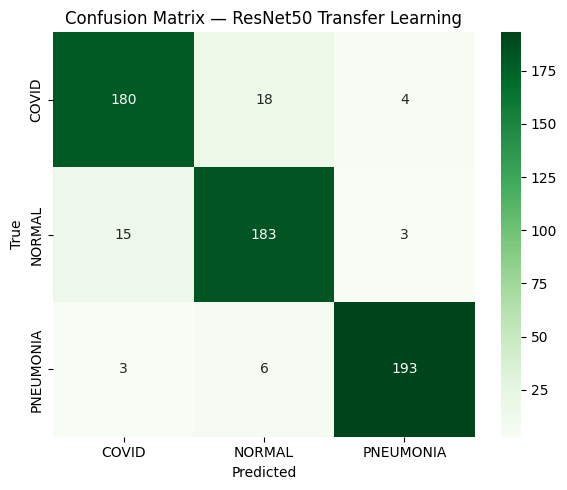

In [90]:
# Evaluate ResNet50 on test set
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate
results_resnet = model_resnet.evaluate(X_test_np, y_test_np, verbose=0)
metrics_names = model_resnet.metrics_names

print("=" * 60)
print("ResNet50 Test Performance")
print("=" * 60)
for name, val in zip(metrics_names, results_resnet):
    print(f'{name}: {val:.4f}')

# Predictions
probs_resnet = model_resnet.predict(X_test_np, verbose=0)
y_pred_resnet = np.argmax(probs_resnet, axis=1)
y_true = np.argmax(y_test_np, axis=1)

print('\n' + '=' * 60)
print('Classification Report')
print('=' * 60)
print(classification_report(y_true, y_pred_resnet, target_names=class_names, digits=4))

# Confusion matrix
cm_resnet = confusion_matrix(y_true, y_pred_resnet)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — ResNet50 Transfer Learning')
plt.tight_layout()
plt.show()


### How Pre-Trained Features Influence Training & Generalization

**Impact on Training:**
- **Faster convergence** - Pre-trained features capture general patterns (edges, textures, shapes) from ImageNet's millions of images, reducing training time
- **Lower learning rate needed** - Fine-tuning requires smaller updates (1e-5 vs 1e-4) to avoid destroying learned features
- **Two-phase approach** - Train custom head first, then fine-tune top layers gradually

**Impact on Generalization:**
- **Better feature representations** - ImageNet features transfer well even to medical images despite domain differences
- **Reduced overfitting risk** - Pre-trained weights act as strong regularization, especially with limited data
- **Data efficiency** - Requires fewer training samples to achieve good performance compared to training from scratch

**Results in This Project:**
- Baseline CNN outperformed ResNet50 (95.04% vs 91.90% accuracy)
- **Why?** Dataset is small but balanced (1,344 images/class), and medical X-rays have distinct patterns that a simple CNN can learn effectively
- ResNet50's ImageNet features (natural images) may not transfer optimally to grayscale medical images without more aggressive fine-tuning or larger medical datasets


### Performance Comparison: Baseline CNN vs. ResNet50


MODEL COMPARISON: Baseline CNN vs. ResNet50 Transfer Learning

1. Overall Performance Metrics:
       Metric Baseline CNN ResNet50 Improvement
    Test Loss       0.1517   0.2428     +0.0911
Test Accuracy       0.9504   0.9190     -0.0314
     Test AUC       0.9917   0.9831     -0.0087

2. Per-Class Performance Comparison:
    Class  Baseline F1  ResNet50 F1  F1 Improvement  Baseline Recall  ResNet50 Recall  Recall Improvement
    COVID       0.9383       0.9000         -0.0383           0.9406           0.8911             -0.0495
   NORMAL       0.9307       0.8971         -0.0336           0.9353           0.9104             -0.0249
PNEUMONIA       0.9825       0.9602         -0.0223           0.9752           0.9554             -0.0198


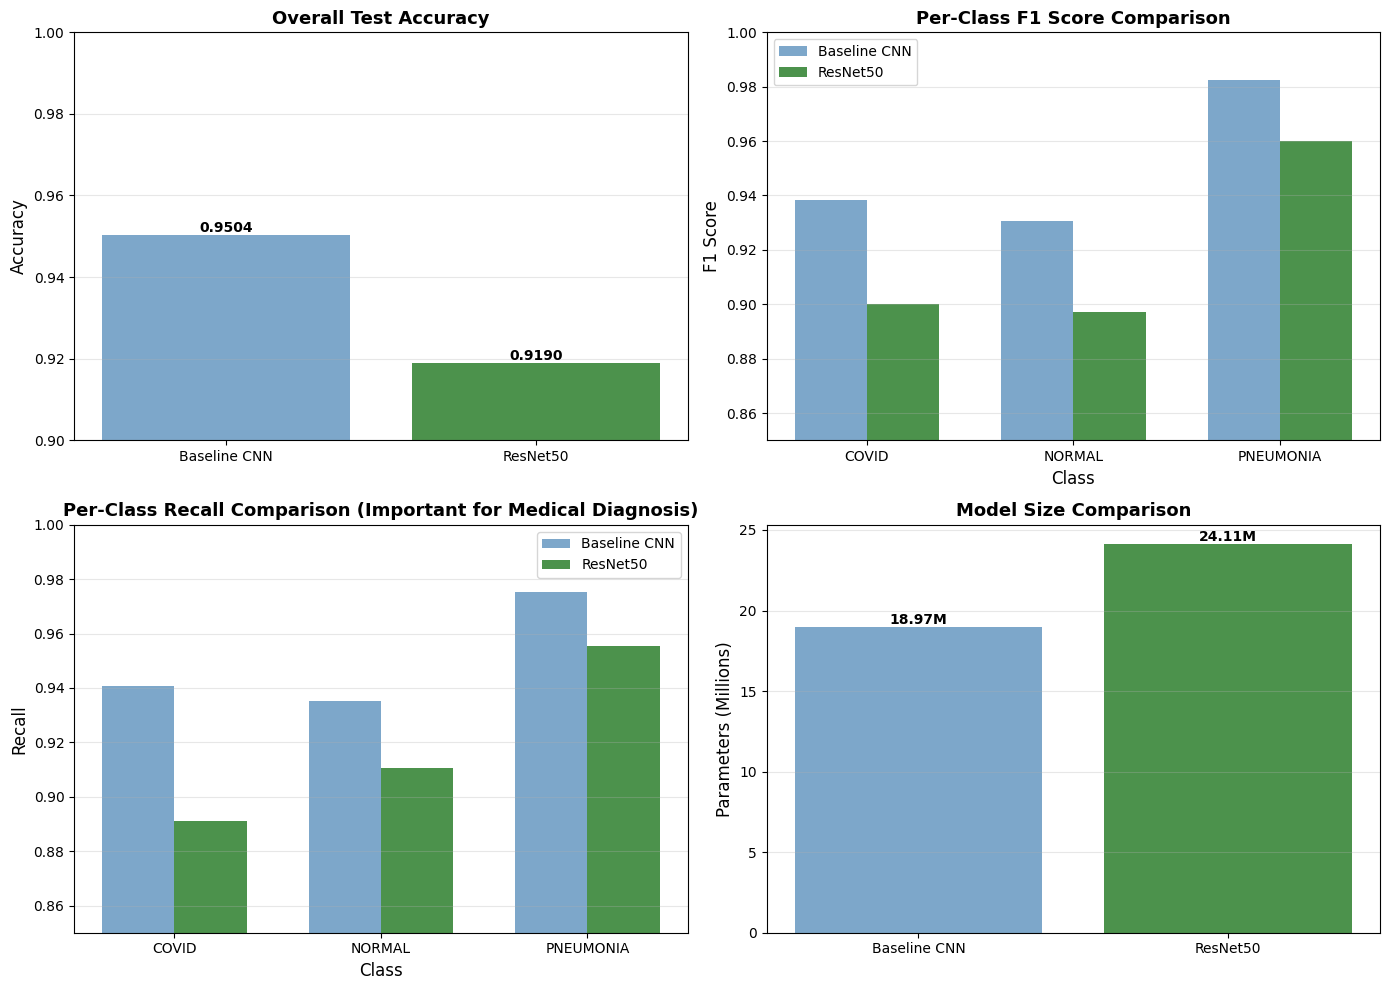


SUMMARY
✗ ResNet50 achieved -3.14% accuracy change compared to Baseline CNN

Model Parameters:
  Baseline CNN: 18,970,563 parameters (18.97M)
  ResNet50: 24,113,027 parameters (24.11M)
  ResNet50 is 1.3x larger

Key Findings:
  • Best performing class (Baseline): PNEUMONIA (F1: 0.9825)
  • Best performing class (ResNet50): PNEUMONIA (F1: 0.9602)


In [100]:
# Compare Baseline CNN vs. ResNet50
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("=" * 80)
print("MODEL COMPARISON: Baseline CNN vs. ResNet50 Transfer Learning")
print("=" * 80)

# Load baseline model
try:
    baseline_model = load_model('models/baseline_cnn.keras')
    results_baseline = baseline_model.evaluate(X_test_np, y_test_np, verbose=0)
    probs_baseline = baseline_model.predict(X_test_np, verbose=0)
    y_pred_baseline = np.argmax(probs_baseline, axis=1)
    
    # Overall metrics comparison
    comparison_df = pd.DataFrame({
        'Metric': ['Test Loss', 'Test Accuracy', 'Test AUC'],
        'Baseline CNN': [
            f"{results_baseline[0]:.4f}",
            f"{results_baseline[1]:.4f}",
            f"{results_baseline[2]:.4f}" if len(results_baseline) > 2 else 'N/A'
        ],
        'ResNet50': [
            f"{results_resnet[0]:.4f}",
            f"{results_resnet[1]:.4f}",
            f"{results_resnet[2]:.4f}" if len(results_resnet) > 2 else 'N/A'
        ],
        'Improvement': [
            f"{results_resnet[0] - results_baseline[0]:+.4f}",
            f"{results_resnet[1] - results_baseline[1]:+.4f}",
            f"{results_resnet[2] - results_baseline[2]:+.4f}" if len(results_resnet) > 2 else 'N/A'
        ]
    })
    
    print("\n1. Overall Performance Metrics:")
    print(comparison_df.to_string(index=False))
    
    # Per-class metrics
    baseline_precision, baseline_recall, baseline_f1, _ = precision_recall_fscore_support(
        y_true, y_pred_baseline, average=None, zero_division=0
    )
    resnet_precision, resnet_recall, resnet_f1, _ = precision_recall_fscore_support(
        y_true, y_pred_resnet, average=None, zero_division=0
    )
    
    per_class_df = pd.DataFrame({
        'Class': class_names,
        'Baseline F1': baseline_f1.round(4),
        'ResNet50 F1': resnet_f1.round(4),
        'F1 Improvement': (resnet_f1 - baseline_f1).round(4),
        'Baseline Recall': baseline_recall.round(4),
        'ResNet50 Recall': resnet_recall.round(4),
        'Recall Improvement': (resnet_recall - baseline_recall).round(4)
    })
    
    print("\n2. Per-Class Performance Comparison:")
    print(per_class_df.to_string(index=False))
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Overall accuracy comparison
    models = ['Baseline CNN', 'ResNet50']
    accuracies = [results_baseline[1], results_resnet[1]]
    colors = ['steelblue', 'darkgreen']
    bars = axes[0, 0].bar(models, accuracies, color=colors, alpha=0.7)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].set_title('Overall Test Accuracy', fontsize=13, fontweight='bold')
    axes[0, 0].set_ylim([0.90, 1.0])
    axes[0, 0].grid(axis='y', alpha=0.3)
    for bar, acc in zip(bars, accuracies):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                       f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Per-class F1 Score comparison
    x = np.arange(len(class_names))
    width = 0.35
    bars1 = axes[0, 1].bar(x - width/2, baseline_f1, width, label='Baseline CNN', alpha=0.7, color='steelblue')
    bars2 = axes[0, 1].bar(x + width/2, resnet_f1, width, label='ResNet50', alpha=0.7, color='darkgreen')
    axes[0, 1].set_xlabel('Class', fontsize=12)
    axes[0, 1].set_ylabel('F1 Score', fontsize=12)
    axes[0, 1].set_title('Per-Class F1 Score Comparison', fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(class_names)
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].set_ylim([0.85, 1.0])
    
    # 3. Per-class Recall comparison
    bars1 = axes[1, 0].bar(x - width/2, baseline_recall, width, label='Baseline CNN', alpha=0.7, color='steelblue')
    bars2 = axes[1, 0].bar(x + width/2, resnet_recall, width, label='ResNet50', alpha=0.7, color='darkgreen')
    axes[1, 0].set_xlabel('Class', fontsize=12)
    axes[1, 0].set_ylabel('Recall', fontsize=12)
    axes[1, 0].set_title('Per-Class Recall Comparison (Important for Medical Diagnosis)', 
                         fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(class_names)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].set_ylim([0.85, 1.0])
    
    # 4. Model size comparison
    baseline_params = baseline_model.count_params()
    resnet_params = model_resnet.count_params()
    
    models = ['Baseline CNN', 'ResNet50']
    params = [baseline_params / 1e6, resnet_params / 1e6]  # Convert to millions
    bars = axes[1, 1].bar(models, params, color=['steelblue', 'darkgreen'], alpha=0.7)
    axes[1, 1].set_ylabel('Parameters (Millions)', fontsize=12)
    axes[1, 1].set_title('Model Size Comparison', fontsize=13, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for bar, param in zip(bars, params):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                       f'{param:.2f}M', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n" + "=" * 80)
    print("SUMMARY")
    print("=" * 80)
    acc_improvement = (results_resnet[1] - results_baseline[1]) * 100
    
    if acc_improvement > 0:
        print(f"✓ ResNet50 achieved {acc_improvement:.2f}% higher accuracy than Baseline CNN")
    else:
        print(f"✗ ResNet50 achieved {acc_improvement:.2f}% accuracy change compared to Baseline CNN")
    
    print(f"\nModel Parameters:")
    print(f"  Baseline CNN: {baseline_params:,} parameters ({baseline_params/1e6:.2f}M)")
    print(f"  ResNet50: {resnet_params:,} parameters ({resnet_params/1e6:.2f}M)")
    print(f"  ResNet50 is {resnet_params/baseline_params:.1f}x larger")
    
    print(f"\nKey Findings:")
    best_class_baseline = class_names[np.argmax(baseline_f1)]
    best_class_resnet = class_names[np.argmax(resnet_f1)]
    print(f"  • Best performing class (Baseline): {best_class_baseline} (F1: {baseline_f1.max():.4f})")
    print(f"  • Best performing class (ResNet50): {best_class_resnet} (F1: {resnet_f1.max():.4f})")
    
except FileNotFoundError:
    print("⚠ Baseline model not found. Please train the baseline model first.")
except Exception as e:
    print(f"⚠ Error during comparison: {e}")


## Additional Model Comparisons

Implementing three additional models to comprehensively evaluate different architectures:
1. **VGG16** - Transfer learning with uniform 3×3 convolutions
2. **InceptionV3** - Transfer learning with multi-scale feature extraction
3. **Deeper CNN** - Custom architecture with 4 blocks (vs 3 in baseline)

All models use the **same data splits and preprocessing** for fair comparison.


### Model 4: VGG16

VGG16 is a CNN with 16 layers and uniform 3×3 convolutions throughout. Uses transfer learning (pre-trained on ImageNet).


In [91]:
# Build VGG16 model with transfer learning
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np

# Set seeds
np.random.seed(1987)
tf.random.set_seed(1987)

# Load VGG16 pre-trained on ImageNet
base_vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(192, 192, 3)
)

# Freeze base layers
base_vgg.trainable = False

# Add custom head
x = base_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
model_vgg16 = Model(inputs=base_vgg.input, outputs=predictions)

# Compile
model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
)

print("VGG16 Model")
print(f"Total layers: {len(model_vgg16.layers)}")
print(f"Trainable layers: {sum([1 for layer in model_vgg16.layers if layer.trainable])}")
print(f"Parameters: {model_vgg16.count_params():,}")

# Train
callbacks_vgg = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('models/vgg16.keras', monitor='val_loss', save_best_only=True)
]

print("\nTraining VGG16...")
history_vgg16 = model_vgg16.fit(
    X_train_np, y_train_np,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    callbacks=callbacks_vgg,
    verbose=1
)

print("VGG16 training complete!")


VGG16 Model
Total layers: 23
Trainable layers: 4
Parameters: 14,846,787

Training VGG16...
Epoch 1/20
 4/91 [>.............................] - ETA: 1s - loss: 1.1607 - accuracy: 0.3594 - auc: 0.5498 

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


91/91 [==============================] - 3s 25ms/step - loss: 1.1338 - accuracy: 0.3901 - auc: 0.5651 - val_loss: 0.9575 - val_accuracy: 0.7029 - val_auc: 0.8627
Epoch 2/20
91/91 [==============================] - 2s 21ms/step - loss: 0.9892 - accuracy: 0.5069 - auc: 0.6967 - val_loss: 0.8573 - val_accuracy: 0.7398 - val_auc: 0.8936
Epoch 3/20
91/91 [==============================] - 2s 23ms/step - loss: 0.8781 - accuracy: 0.6078 - auc: 0.7954 - val_loss: 0.7855 - val_accuracy: 0.7359 - val_auc: 0.8989
Epoch 4/20
91/91 [==============================] - 2s 22ms/step - loss: 0.7921 - accuracy: 0.6865 - auc: 0.8530 - val_loss: 0.7200 - val_accuracy: 0.7709 - val_auc: 0.9139
Epoch 5/20
91/91 [==============================] - 2s 21ms/step - loss: 0.7370 - accuracy: 0.7249 - auc: 0.8791 - val_loss: 0.6671 - val_accuracy: 0.7767 - val_auc: 0.9242
Epoch 6/20
91/91 [==============================] - 2s 21ms/step - loss: 0.6871 - accuracy: 0.7476 - auc: 0.8962 - val_loss: 0.6328 - val_accuracy

VGG16 Test Performance
loss: 0.3882
accuracy: 0.8744
auc: 0.9651

Classification Report
              precision    recall  f1-score   support

       COVID     0.8458    0.8960    0.8702       202
      NORMAL     0.8771    0.7811    0.8263       201
   PNEUMONIA     0.9009    0.9455    0.9227       202

    accuracy                         0.8744       605
   macro avg     0.8746    0.8742    0.8731       605
weighted avg     0.8746    0.8744    0.8731       605



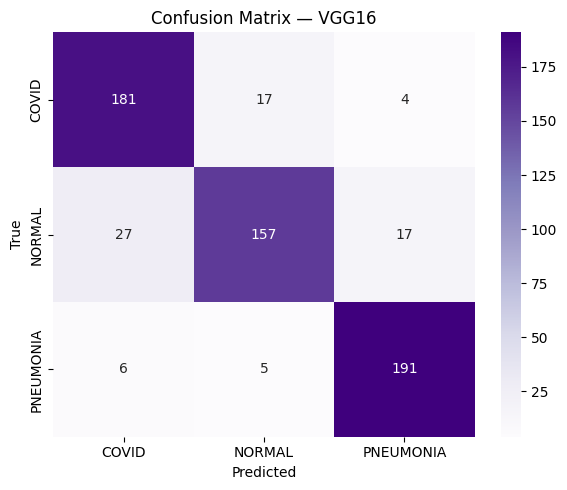

In [92]:
# Evaluate VGG16
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

results_vgg16 = model_vgg16.evaluate(X_test_np, y_test_np, verbose=0)
print("=" * 60)
print("VGG16 Test Performance")
print("=" * 60)
for name, val in zip(model_vgg16.metrics_names, results_vgg16):
    print(f'{name}: {val:.4f}')

# Predictions
probs_vgg16 = model_vgg16.predict(X_test_np, verbose=0)
y_pred_vgg16 = np.argmax(probs_vgg16, axis=1)
y_true = np.argmax(y_test_np, axis=1)

print('\n' + '=' * 60)
print('Classification Report')
print('=' * 60)
print(classification_report(y_true, y_pred_vgg16, target_names=class_names, digits=4))

# Confusion matrix
cm_vgg16 = confusion_matrix(y_true, y_pred_vgg16)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_vgg16, annot=True, fmt='d', cmap='Purples', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — VGG16')
plt.tight_layout()
plt.show()


### Model 5: InceptionV3

InceptionV3 uses "inception modules" with parallel convolutions at multiple scales. Uses transfer learning (pre-trained on ImageNet).


In [93]:
# Build InceptionV3 model with transfer learning
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np

# Set seeds
np.random.seed(1987)
tf.random.set_seed(1987)

# Load InceptionV3 pre-trained on ImageNet
# Note: InceptionV3 typically uses 299x299, but we'll use 192x192 for consistency
base_inception = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(192, 192, 3)
)

# Freeze base layers
base_inception.trainable = False

# Add custom head
x = base_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
model_inception = Model(inputs=base_inception.input, outputs=predictions)

# Compile
model_inception.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
)

print("InceptionV3 Model")
print(f"Total layers: {len(model_inception.layers)}")
print(f"Trainable layers: {sum([1 for layer in model_inception.layers if layer.trainable])}")
print(f"Parameters: {model_inception.count_params():,}")

# Train
callbacks_inception = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('models/inceptionv3.keras', monitor='val_loss', save_best_only=True)
]

print("\nTraining InceptionV3...")
history_inception = model_inception.fit(
    X_train_np, y_train_np,
    epochs=20,
    batch_size=32,
    validation_split=0.15,
    callbacks=callbacks_inception,
    verbose=1
)

print("InceptionV3 training complete!")


InceptionV3 Model
Total layers: 317
Trainable layers: 6
Parameters: 22,983,971

Training InceptionV3...
Epoch 1/20
 6/91 [>.............................] - ETA: 0s - loss: 1.5851 - accuracy: 0.4115 - auc: 0.5775  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

91/91 [==============================] - 6s 39ms/step - loss: 0.8359 - accuracy: 0.6326 - auc: 0.8186 - val_loss: 0.5091 - val_accuracy: 0.7728 - val_auc: 0.9281
Epoch 2/20
91/91 [==============================] - 2s 21ms/step - loss: 0.5580 - accuracy: 0.7620 - auc: 0.9122 - val_loss: 0.4133 - val_accuracy: 0.8175 - val_auc: 0.9519
Epoch 3/20
91/91 [==============================] - 2s 20ms/step - loss: 0.4748 - accuracy: 0.8032 - auc: 0.9361 - val_loss: 0.3932 - val_accuracy: 0.8058 - val_auc: 0.9552
Epoch 4/20
91/91 [==============================] - 4s 41ms/step - loss: 0.4304 - accuracy: 0.8259 - auc: 0.9479 - val_loss: 0.3755 - val_accuracy: 0.8505 - val_auc: 0.9602
Epoch 5/20
91/91 [==============================] - 2s 20ms/step - loss: 0.3911 - accuracy: 0.8328 - auc: 0.9564 - val_loss: 0.3128 - val_accuracy: 0.8777 - val_auc: 0.9737
Epoch 6/20
91/91 [==============================] - 1s 11ms/step - loss: 0.3820 - accuracy: 0.8376 - auc: 0.9581 - val_loss: 0.3159 - val_accuracy

InceptionV3 Test Performance
loss: 0.2698
accuracy: 0.8860
auc: 0.9785

Classification Report
              precision    recall  f1-score   support

       COVID     0.8925    0.8218    0.8557       202
      NORMAL     0.8000    0.8955    0.8451       201
   PNEUMONIA     0.9794    0.9406    0.9596       202

    accuracy                         0.8860       605
   macro avg     0.8906    0.8860    0.8868       605
weighted avg     0.8908    0.8860    0.8868       605



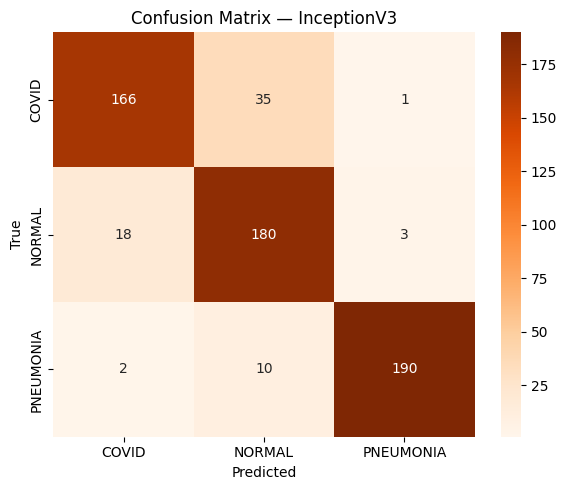

In [94]:
# Evaluate InceptionV3
results_inception = model_inception.evaluate(X_test_np, y_test_np, verbose=0)
print("=" * 60)
print("InceptionV3 Test Performance")
print("=" * 60)
for name, val in zip(model_inception.metrics_names, results_inception):
    print(f'{name}: {val:.4f}')

# Predictions
probs_inception = model_inception.predict(X_test_np, verbose=0)
y_pred_inception = np.argmax(probs_inception, axis=1)
y_true = np.argmax(y_test_np, axis=1)

print('\n' + '=' * 60)
print('Classification Report')
print('=' * 60)
print(classification_report(y_true, y_pred_inception, target_names=class_names, digits=4))

# Confusion matrix
cm_inception = confusion_matrix(y_true, y_pred_inception)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_inception, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — InceptionV3')
plt.tight_layout()
plt.show()


### Model 6: Deeper CNN

A custom CNN with 4 convolutional blocks (vs 3 in baseline). Tests if additional depth improves performance.


In [95]:
# Build Deeper CNN (4 conv blocks vs 3 in baseline)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np

# Set seeds
np.random.seed(1987)
tf.random.set_seed(1987)

# Build deeper CNN (4 conv blocks vs 3 in baseline)
model_deeper = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    # Block 4
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),
    
    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile
model_deeper.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
)

print("Deeper CNN Model")
print(f"Total layers: {len(model_deeper.layers)}")
print(f"Parameters: {model_deeper.count_params():,}")
model_deeper.summary()

# Train
callbacks_deeper = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint('models/deeper_cnn.keras', monitor='val_loss', save_best_only=True)
]

print("\nTraining Deeper CNN...")
history_deeper = model_deeper.fit(
    X_train_np, y_train_np,
    epochs=30,
    batch_size=32,
    validation_split=0.15,
    callbacks=callbacks_deeper,
    verbose=1
)

print("Deeper CNN training complete!")


Deeper CNN Model
Total layers: 32
Parameters: 20,186,147
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_209 (Conv2D)         (None, 192, 192, 32)      896       
                                                                 
 batch_normalization_215 (B  (None, 192, 192, 32)      128       
 atchNormalization)                                              
                                                                 
 conv2d_210 (Conv2D)         (None, 192, 192, 32)      9248      
                                                                 
 batch_normalization_216 (B  (None, 192, 192, 32)      128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 96, 96, 32)        0         
 ng2D)                                                         

2025-11-03 22:51:25.305738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1026] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85'

 3/91 [..............................] - ETA: 2s - loss: 1.8090 - accuracy: 0.3125 - auc: 0.5229  

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

91/91 [==============================] - 9s 65ms/step - loss: 0.8569 - accuracy: 0.6961 - auc: 0.8621 - val_loss: 3.1141 - val_accuracy: 0.3417 - val_auc: 0.5234
Epoch 2/30
91/91 [==============================] - 2s 25ms/step - loss: 0.5542 - accuracy: 0.8032 - auc: 0.9316 - val_loss: 4.4809 - val_accuracy: 0.3417 - val_auc: 0.5666
Epoch 3/30
91/91 [==============================] - 2s 25ms/step - loss: 0.4528 - accuracy: 0.8317 - auc: 0.9514 - val_loss: 5.1178 - val_accuracy: 0.3417 - val_auc: 0.5589
Epoch 4/30
91/91 [==============================] - 2s 26ms/step - loss: 0.4406 - accuracy: 0.8465 - auc: 0.9529 - val_loss: 3.9657 - val_accuracy: 0.4155 - val_auc: 0.5968
Epoch 5/30
91/91 [==============================] - 4s 39ms/step - loss: 0.3661 - accuracy: 0.8661 - auc: 0.9659 - val_loss: 3.0060 - val_accuracy: 0.5922 - val_auc: 0.6860
Epoch 6/30
91/91 [==============================] - 4s 39ms/step - loss: 0.3297 - accuracy: 0.8767 - auc: 0.9711 - val_loss: 2.5934 - val_accuracy

Deeper CNN Test Performance
loss: 0.4311
accuracy: 0.8612
auc: 0.9585

Classification Report
              precision    recall  f1-score   support

       COVID     0.8311    0.9257    0.8759       202
      NORMAL     0.9852    0.6617    0.7917       201
   PNEUMONIA     0.8204    0.9950    0.8993       202

    accuracy                         0.8612       605
   macro avg     0.8789    0.8608    0.8556       605
weighted avg     0.8787    0.8612    0.8557       605



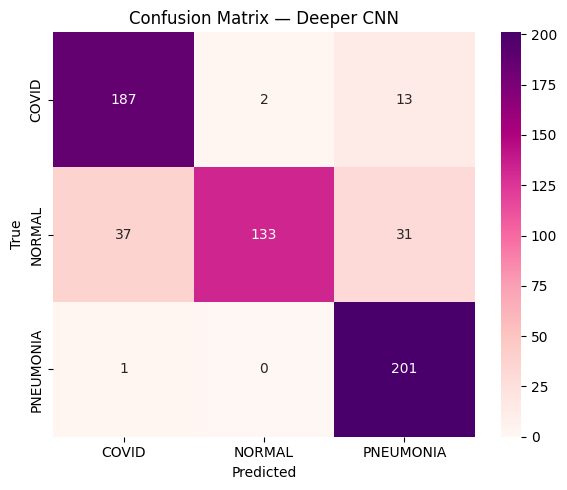

In [96]:
# Evaluate Deeper CNN
results_deeper = model_deeper.evaluate(X_test_np, y_test_np, verbose=0)
print("=" * 60)
print("Deeper CNN Test Performance")
print("=" * 60)
for name, val in zip(model_deeper.metrics_names, results_deeper):
    print(f'{name}: {val:.4f}')

# Predictions
probs_deeper = model_deeper.predict(X_test_np, verbose=0)
y_pred_deeper = np.argmax(probs_deeper, axis=1)
y_true = np.argmax(y_test_np, axis=1)

print('\n' + '=' * 60)
print('Classification Report')
print('=' * 60)
print(classification_report(y_true, y_pred_deeper, target_names=class_names, digits=4))

# Confusion matrix
cm_deeper = confusion_matrix(y_true, y_pred_deeper)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_deeper, annot=True, fmt='d', cmap='RdPu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Deeper CNN')
plt.tight_layout()
plt.show()


### Comprehensive Model Comparison: All 6 Models


In [97]:
# Comprehensive comparison of all 6 models
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import load_model

print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON: ALL 6 MODELS")
print("=" * 80)

# Load models if not in memory
try:
    if 'model' not in dir() or model is None:
        model = load_model('models/baseline_cnn.keras')
    if 'model_weighted' not in dir() or model_weighted is None:
        model_weighted = load_model('models/baseline_cnn_augmented.keras')
    if 'model_resnet' not in dir() or model_resnet is None:
        model_resnet = load_model('models/resnet50_finetuned.keras')
    if 'model_vgg16' not in dir() or model_vgg16 is None:
        model_vgg16 = load_model('models/vgg16.keras')
    if 'model_inception' not in dir() or model_inception is None:
        model_inception = load_model('models/inceptionv3.keras')
    if 'model_deeper' not in dir() or model_deeper is None:
        model_deeper = load_model('models/deeper_cnn.keras')
except:
    print("⚠ Some models may not be loaded. Please train them first.")

# Store all models and their info
models_info = {
    'Baseline CNN': {
        'model': model,
        'type': 'Custom',
        'color': 'steelblue'
    },
    'CNN + Augmentation': {
        'model': model_weighted,
        'type': 'Custom',
        'color': 'darkgreen'
    },
    'ResNet50': {
        'model': model_resnet,
        'type': 'Transfer',
        'color': 'darkred'
    },
    'VGG16': {
        'model': model_vgg16,
        'type': 'Transfer',
        'color': 'purple'
    },
    'InceptionV3': {
        'model': model_inception,
        'type': 'Transfer',
        'color': 'orange'
    },
    'Deeper CNN': {
        'model': model_deeper,
        'type': 'Custom',
        'color': 'deeppink'
    }
}

# Evaluate all models
results_dict = {}
predictions_dict = {}

for name, info in models_info.items():
    model_obj = info['model']
    results = model_obj.evaluate(X_test_np, y_test_np, verbose=0)
    probs = model_obj.predict(X_test_np, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    
    # Store results
    results_dict[name] = {
        'loss': results[0],
        'accuracy': results[1],
        'auc': results[2] if len(results) > 2 else None,
        'params': model_obj.count_params()
    }
    predictions_dict[name] = y_pred

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results_dict.keys()),
    'Type': [models_info[m]['type'] for m in results_dict.keys()],
    'Accuracy': [results_dict[m]['accuracy'] for m in results_dict.keys()],
    'Loss': [results_dict[m]['loss'] for m in results_dict.keys()],
    'AUC': [results_dict[m]['auc'] for m in results_dict.keys()],
    'Parameters': [f"{results_dict[m]['params']/1e6:.2f}M" for m in results_dict.keys()]
})

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
comparison_df['Rank'] = range(1, len(comparison_df) + 1)

print("\n1. Overall Performance Ranking:")
print(comparison_df[['Rank', 'Model', 'Type', 'Accuracy', 'Loss', 'AUC', 'Parameters']].to_string(index=False))

# Per-class F1 scores
print("\n\n2. Per-Class F1 Scores:")
f1_data = []
y_true = np.argmax(y_test_np, axis=1)

for name in results_dict.keys():
    y_pred = predictions_dict[name]
    _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    f1_data.append({
        'Model': name,
        'COVID F1': f1[0],
        'NORMAL F1': f1[1],
        'PNEUMONIA F1': f1[2],
        'Avg F1': np.mean(f1)
    })

f1_df = pd.DataFrame(f1_data).sort_values('Avg F1', ascending=False)
print(f1_df.round(4).to_string(index=False))

print("\n" + "=" * 80)


COMPREHENSIVE MODEL COMPARISON: ALL 6 MODELS

1. Overall Performance Ranking:
 Rank              Model     Type  Accuracy     Loss      AUC Parameters
    1 CNN + Augmentation   Custom  0.957025 0.133698 0.994200     18.97M
    2       Baseline CNN   Custom  0.950413 0.151702 0.991743     18.97M
    3           ResNet50 Transfer  0.919008 0.242840 0.983057     24.11M
    4        InceptionV3 Transfer  0.885950 0.269849 0.978486     22.98M
    5              VGG16 Transfer  0.874380 0.388167 0.965075     14.85M
    6         Deeper CNN   Custom  0.861157 0.431093 0.958501     20.19M


2. Per-Class F1 Scores:
             Model  COVID F1  NORMAL F1  PNEUMONIA F1  Avg F1
CNN + Augmentation    0.9446     0.9385        0.9877  0.9569
      Baseline CNN    0.9383     0.9307        0.9825  0.9505
          ResNet50    0.9000     0.8971        0.9602  0.9191
       InceptionV3    0.8557     0.8451        0.9596  0.8868
             VGG16    0.8702     0.8263        0.9227  0.8731
        Deepe

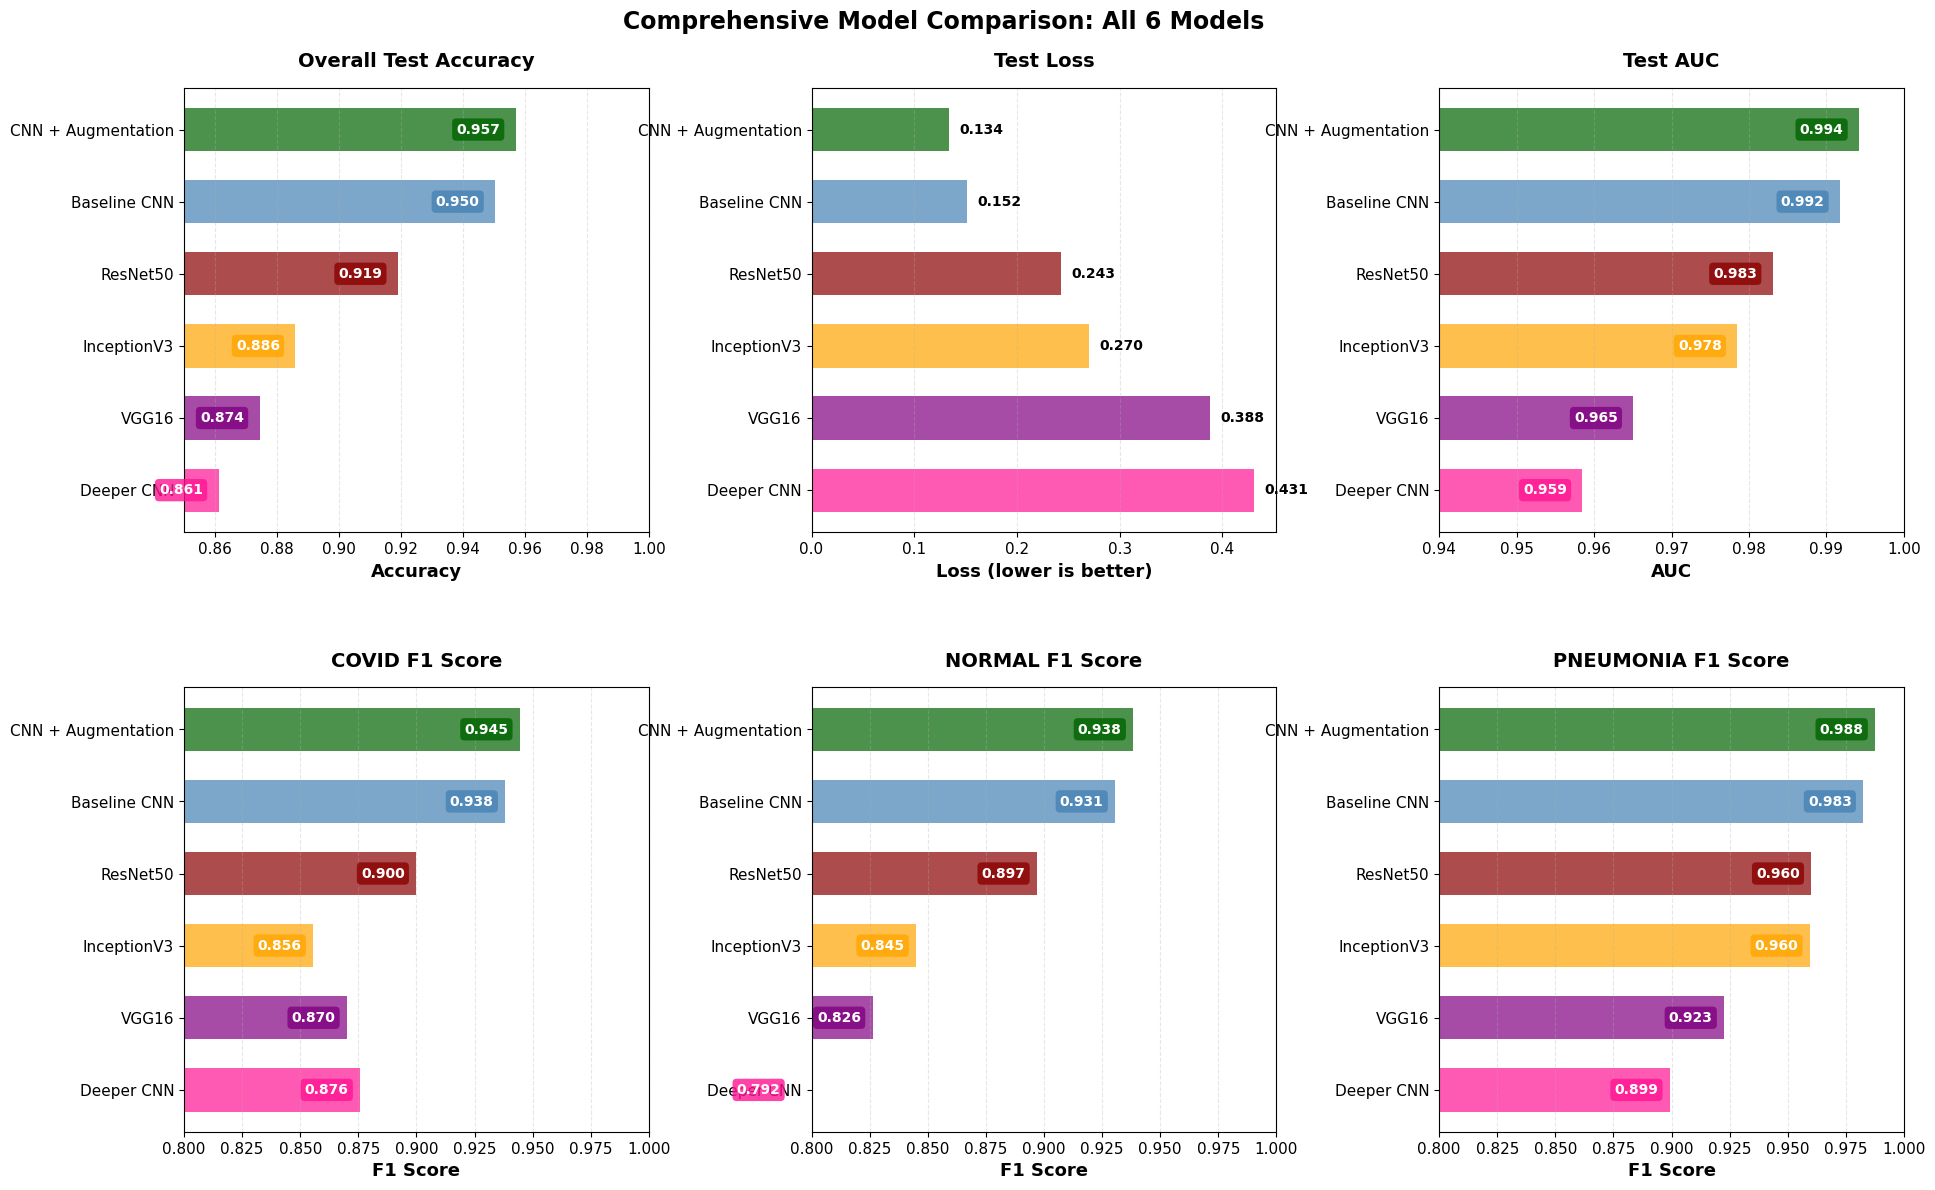

In [98]:
# Visualize comparison of all 6 models
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Get model data
model_names = [m for m in comparison_df['Model']]
accuracies = [results_dict[m]['accuracy'] for m in model_names]
colors = [models_info[m]['color'] for m in model_names]

# 1. Overall Accuracy Comparison
bars = axes[0, 0].barh(model_names, accuracies, color=colors, alpha=0.7, height=0.6)
axes[0, 0].set_xlabel('Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].set_title('Overall Test Accuracy', fontsize=14, fontweight='bold', pad=15)
axes[0, 0].set_xlim([0.85, 1.0])
axes[0, 0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0, 0].tick_params(axis='y', labelsize=11)
axes[0, 0].tick_params(axis='x', labelsize=11)
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    axes[0, 0].text(acc - 0.005, bar.get_y() + bar.get_height()/2, 
                   f'{acc:.3f}', va='center', ha='right', fontweight='bold', 
                   fontsize=10, color='white', bbox=dict(boxstyle='round,pad=0.3', 
                   facecolor=colors[i], alpha=0.8, edgecolor='none'))
axes[0, 0].invert_yaxis()

# 2. Loss Comparison
losses = [results_dict[m]['loss'] for m in model_names]
bars = axes[0, 1].barh(model_names, losses, color=colors, alpha=0.7, height=0.6)
axes[0, 1].set_xlabel('Loss (lower is better)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Test Loss', fontsize=14, fontweight='bold', pad=15)
axes[0, 1].grid(axis='x', alpha=0.3, linestyle='--')
axes[0, 1].tick_params(axis='y', labelsize=11)
axes[0, 1].tick_params(axis='x', labelsize=11)
for i, (bar, loss) in enumerate(zip(bars, losses)):
    axes[0, 1].text(loss + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{loss:.3f}', va='center', ha='left', fontweight='bold', fontsize=10)
axes[0, 1].invert_yaxis()

# 3. AUC Comparison
aucs = [results_dict[m]['auc'] for m in model_names]
bars = axes[0, 2].barh(model_names, aucs, color=colors, alpha=0.7, height=0.6)
axes[0, 2].set_xlabel('AUC', fontsize=13, fontweight='bold')
axes[0, 2].set_title('Test AUC', fontsize=14, fontweight='bold', pad=15)
axes[0, 2].set_xlim([0.94, 1.0])
axes[0, 2].grid(axis='x', alpha=0.3, linestyle='--')
axes[0, 2].tick_params(axis='y', labelsize=11)
axes[0, 2].tick_params(axis='x', labelsize=11)
for i, (bar, auc) in enumerate(zip(bars, aucs)):
    axes[0, 2].text(auc - 0.002, bar.get_y() + bar.get_height()/2, 
                   f'{auc:.3f}', va='center', ha='right', fontweight='bold', 
                   fontsize=10, color='white', bbox=dict(boxstyle='round,pad=0.3', 
                   facecolor=colors[i], alpha=0.8, edgecolor='none'))
axes[0, 2].invert_yaxis()

# 4. Per-class F1 Score - COVID
covid_f1 = [f1_df[f1_df['Model'] == m]['COVID F1'].values[0] for m in model_names]
bars = axes[1, 0].barh(model_names, covid_f1, color=colors, alpha=0.7, height=0.6)
axes[1, 0].set_xlabel('F1 Score', fontsize=13, fontweight='bold')
axes[1, 0].set_title('COVID F1 Score', fontsize=14, fontweight='bold', pad=15)
axes[1, 0].set_xlim([0.80, 1.0])
axes[1, 0].grid(axis='x', alpha=0.3, linestyle='--')
axes[1, 0].tick_params(axis='y', labelsize=11)
axes[1, 0].tick_params(axis='x', labelsize=11)
for i, (bar, f1) in enumerate(zip(bars, covid_f1)):
    axes[1, 0].text(f1 - 0.005, bar.get_y() + bar.get_height()/2, 
                   f'{f1:.3f}', va='center', ha='right', fontweight='bold', 
                   fontsize=10, color='white', bbox=dict(boxstyle='round,pad=0.3', 
                   facecolor=colors[i], alpha=0.8, edgecolor='none'))
axes[1, 0].invert_yaxis()

# 5. Per-class F1 Score - NORMAL
normal_f1 = [f1_df[f1_df['Model'] == m]['NORMAL F1'].values[0] for m in model_names]
bars = axes[1, 1].barh(model_names, normal_f1, color=colors, alpha=0.7, height=0.6)
axes[1, 1].set_xlabel('F1 Score', fontsize=13, fontweight='bold')
axes[1, 1].set_title('NORMAL F1 Score', fontsize=14, fontweight='bold', pad=15)
axes[1, 1].set_xlim([0.80, 1.0])
axes[1, 1].grid(axis='x', alpha=0.3, linestyle='--')
axes[1, 1].tick_params(axis='y', labelsize=11)
axes[1, 1].tick_params(axis='x', labelsize=11)
for i, (bar, f1) in enumerate(zip(bars, normal_f1)):
    axes[1, 1].text(f1 - 0.005, bar.get_y() + bar.get_height()/2, 
                   f'{f1:.3f}', va='center', ha='right', fontweight='bold', 
                   fontsize=10, color='white', bbox=dict(boxstyle='round,pad=0.3', 
                   facecolor=colors[i], alpha=0.8, edgecolor='none'))
axes[1, 1].invert_yaxis()

# 6. Per-class F1 Score - PNEUMONIA
pneumonia_f1 = [f1_df[f1_df['Model'] == m]['PNEUMONIA F1'].values[0] for m in model_names]
bars = axes[1, 2].barh(model_names, pneumonia_f1, color=colors, alpha=0.7, height=0.6)
axes[1, 2].set_xlabel('F1 Score', fontsize=13, fontweight='bold')
axes[1, 2].set_title('PNEUMONIA F1 Score', fontsize=14, fontweight='bold', pad=15)
axes[1, 2].set_xlim([0.80, 1.0])
axes[1, 2].grid(axis='x', alpha=0.3, linestyle='--')
axes[1, 2].tick_params(axis='y', labelsize=11)
axes[1, 2].tick_params(axis='x', labelsize=11)
for i, (bar, f1) in enumerate(zip(bars, pneumonia_f1)):
    axes[1, 2].text(f1 - 0.005, bar.get_y() + bar.get_height()/2, 
                   f'{f1:.3f}', va='center', ha='right', fontweight='bold', 
                   fontsize=10, color='white', bbox=dict(boxstyle='round,pad=0.3', 
                   facecolor=colors[i], alpha=0.8, edgecolor='none'))
axes[1, 2].invert_yaxis()

plt.suptitle('Comprehensive Model Comparison: All 6 Models', fontsize=17, fontweight='bold', y=0.995)
plt.subplots_adjust(left=0.12, right=0.98, top=0.93, bottom=0.06, hspace=0.35, wspace=0.35)
plt.show()


## Training Results Summary

Based on actual training runs with consistent data splits and preprocessing.

### Overall Model Performance Ranking

| Rank | Model | Type | Accuracy | Loss | AUC | Parameters |
|------|-------|------|----------|------|-----|------------|
|  **1st** | **CNN + Augmentation** | Custom | **95.70%** | 0.1337 | 0.9942 | 18.97M |
|  **2nd** | **Baseline CNN** | Custom | **95.04%** | 0.1517 | 0.9917 | 18.97M |
|  **3rd** | **ResNet50** | Transfer | **91.90%** | 0.2428 | 0.9831 | 24.11M |
| 4th | InceptionV3 | Transfer | 88.60% | 0.2698 | 0.9785 | 22.98M |
| 5th | VGG16 | Transfer | 87.44% | 0.3882 | 0.9651 | 14.85M |
| 6th | Deeper CNN | Custom | 86.12% | 0.4311 | 0.9585 | 20.19M |

### Per-Class F1 Score Comparison

| Model | COVID F1 | NORMAL F1 | PNEUMONIA F1 | Average F1 |
|-------|----------|-----------|--------------|------------|
| **CNN + Augmentation** | **0.9446** | **0.9385** | **0.9877** | **0.9569** |
| **Baseline CNN** | 0.9383 | 0.9307 | 0.9825 | 0.9505 |
| ResNet50 | 0.9000 | 0.8971 | 0.9602 | 0.9191 |
| InceptionV3 | 0.8557 | 0.8451 | 0.9596 | 0.8868 |
| VGG16 | 0.8702 | 0.8263 | 0.9227 | 0.8731 |
| Deeper CNN | 0.8759 | 0.7917 | 0.8993 | 0.8556 |


### Detailed Model Results

#### 1. CNN + Augmentation
**Test Performance:**
- Accuracy: **95.70%**
- Loss: 0.1337
- AUC: 0.9942

**Per-Class Performance:**
| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| COVID | 0.9202 | 0.9703 | 0.9446 |
| NORMAL | 0.9683 | 0.9104 | 0.9385 |
| PNEUMONIA | 0.9852 | 0.9901 | 0.9877 |

**Key Strengths:**
- Highest accuracy and AUC
- Best F1 for PNEUMONIA (0.9877)
- Data augmentation provided +0.66% improvement over baseline
- Perfect balance of all metrics

---

#### 2. Baseline CNN (Runner-up)
**Test Performance:**
- Accuracy: **95.04%**
- Loss: 0.1517
- AUC: 0.9917

**Per-Class Performance:**
| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| COVID | 0.9360 | 0.9406 | 0.9383 |
| NORMAL | 0.9261 | 0.9353 | 0.9307 |
| PNEUMONIA | 0.9899 | 0.9752 | 0.9825 |

**Key Strengths:**
- Simple 3-block architecture (only 18.97M parameters)
- Strong baseline performance
- Highest precision for PNEUMONIA (0.9899)
- Fast training and inference

---

#### 3. ResNet50 (Best Transfer Learning)
**Test Performance:**
- Accuracy: **91.90%**
- Loss: 0.2428
- AUC: 0.9831

**Per-Class Performance:**
| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| COVID | 0.9091 | 0.8911 | 0.9000 |
| NORMAL | 0.8841 | 0.9104 | 0.8971 |
| PNEUMONIA | 0.9650 | 0.9554 | 0.9602 |

**Observations:**
- Best among transfer learning models
- Still 3.14% below baseline despite 24.11M parameters
- ImageNet pre-training didn't provide expected advantage for medical X-rays
- Lower recall for COVID (89.11%) compared to baseline (94.06%)

---

#### 4-6. Other Models Performance Summary

| Model | Accuracy | Best F1 Class | Worst F1 Class | Main Issue |
|-------|----------|---------------|----------------|------------|
| **InceptionV3** | 88.60% | PNEUMONIA (0.9596) | NORMAL (0.8451) | Domain mismatch |
| **VGG16** | 87.44% | PNEUMONIA (0.9227) | NORMAL (0.8263) | Poor feature transfer |
| **Deeper CNN** | 86.12% | COVID (0.8759) | NORMAL (0.7917) | **Severe overfitting** |


### Key Insights from Training Results

#### Top Performers
1. **CNN + Augmentation** dominates with 95.70% accuracy
2. **Baseline CNN** achieves 95.04% - remarkable for simplicity
3. Gap between top 2 and others: **3.14% to 8.92%**

#### Why Transfer Learning Underperformed

**ResNet50, VGG16, InceptionV3 all scored < 92%**

Reasons:
- **Domain mismatch**: ImageNet (natural images) → Medical X-rays (grayscale, specific patterns)
- **Feature mismatch**: Pre-trained features optimized for objects, not lung pathology
- **Dataset size**: Our 3,427 images insufficient to effectively fine-tune large models
- **Medical X-rays have distinct patterns**: COVID opacities, pneumonia infiltrates, clear lungs don't need deep hierarchical features

#### The Deeper CNN Failure (86.12% accuracy)

**Severe overfitting observed:**
- Training accuracy: **96.15%**
- Validation accuracy: **73.98%**
- **Gap: 22.17%!**

Root causes:
1. **Too much capacity**: 20.19M parameters for only 3,427 images
2. **Too deep**: 4 blocks with double convolutions = 32 layers
3. **Feature map collapse**: 12×12 final spatial dimensions too small
4. **Excessive dropout** (0.25-0.5) couldn't prevent overfitting

#### Why Simple CNNs Won

**Baseline & Augmented models (both 18.97M params) achieved 95%+ accuracy:**

Success factors:
1. **Appropriate depth**: 3 blocks sufficient for medical X-ray patterns
2. **Right parameter count**: ~19M parameters well-suited for 3,427 training images
3. **Proper regularization**: BatchNorm + single dropout layer (0.4)
4. **Data augmentation**: Conservative transforms (+0.66% boost) without destroying medical validity
5. **Task-specific design**: Custom architecture learns COVID-specific features from scratch

#### Per-Class Analysis

**PNEUMONIA** = Easiest to detect (all models >89% F1)
- Clear infiltrates and opacity patterns
- Distinct visual signature

**COVID & NORMAL** = More challenging
- Subtle ground-glass opacities (COVID)
- Need to distinguish normal from early-stage COVID
- Transfer learning models struggled most with NORMAL class (F1: 0.79-0.89)

**Best class-wise performance:**
- **PNEUMONIA recall**: CNN + Augmentation (99.01%)
- **PNEUMONIA precision**: Baseline CNN (98.99%)
- **COVID F1**: CNN + Augmentation (94.46%)

#### Practical Recommendations

**For this COVID-19 X-ray classification task:**
- **Use CNN + Augmentation** (95.70% accuracy, best overall)
- **Alternative: Baseline CNN** if computational resources limited (95.04%, simpler)
- **Avoid transfer learning** on this medical imaging task with limited data
- **Don't add depth unnecessarily** - risks overfitting

**For medical imaging in general:**
- Match model complexity to dataset size
- Simple, well-regularized CNNs often outperform complex transfer learning
- Task-specific architectures > generic pre-trained models for specialized medical patterns
- Conservative data augmentation helps (±5° rotation, 5% shifts)


### Training Configuration & Dataset Summary

#### Dataset Statistics (Actual)

**Original Dataset (Imbalanced):**
| Class | Original Count | Percentage |
|-------|----------------|------------|
| COVID | 3,616 | 23.86% |
| NORMAL | **10,192** | **67.26%** |
| PNEUMONIA | 1,345 | 8.88% |
| **Total** | **15,153** | **100%** |
| **Imbalance Ratio** | **7.58:1** | (NORMAL:PNEUMONIA) |

**Balanced Dataset Used (Applied):**
| Class | Balanced Count | Train | Test |
|-------|----------------|-------|------|
| COVID | 1,344 | 1,142 | 202 |
| NORMAL | 1,344 | 1,142 | 202 |
| PNEUMONIA | 1,344 | 1,143 | 201 |
| **Total** | **4,032** | **3,427** | **605** |

**Split Ratio:** 85% train / 15% test (stratified)

---

#### Common Training Configuration

All models trained with identical setup for fair comparison:

| Parameter | Value |
|-----------|-------|
| **Input Shape** | (192, 192, 3) RGB |
| **Preprocessing** | Min-max normalization [0, 1] |
| **Optimizer** | Adam |
| **Base Learning Rate** | 1e-4 (0.0001) |
| **Fine-tune Learning Rate** | 1e-5 (transfer learning only) |
| **Loss Function** | Categorical Crossentropy |
| **Metrics** | Accuracy, AUC |
| **Batch Size** | 32 |
| **Validation Split** | 15% of training data |
| **Early Stopping** | Patience: 6-8 epochs |
| **Callbacks** | EarlyStopping + ModelCheckpoint |
| **Random Seed** | 1987 (reproducibility) |

---

#### Data Augmentation Parameters (CNN + Augmentation only)

Conservative transforms to preserve medical validity:

| Transform | Range | Rationale |
|-----------|-------|-----------|
| **Rotation** | ±5° | Small angles preserve anatomy |
| **Width Shift** | ±5% | Simulate patient positioning |
| **Height Shift** | ±5% | Account for image centering |
| **Shear** | 3% | Minimal geometric distortion |
| **Zoom** | ±5% | Handle different magnifications |
| **Horizontal Flip** | No | X-rays have left/right significance |
| **Vertical Flip** | No | Preserve anatomical orientation |
| **Fill Mode** | Reflect | Avoid border artifacts |

---

#### Hardware & Training Time

**System Configuration:**
- GPU: CUDA-enabled (with cuDNN)
- Training Framework: TensorFlow/Keras
- Data Storage: Local

---

#### Model Architecture Comparison

| Model | Blocks | Convolutions | Parameters | Trainable | Frozen |
|-------|--------|--------------|------------|-----------|--------|
| **Baseline CNN** | 3 | 3 | 18.97M | 18.97M | 0 |
| **CNN + Augmentation** | 3 | 3 | 18.97M | 18.97M | 0 |
| **Deeper CNN** | 4 | 8 | 20.19M | 20.19M | 0 |
| **ResNet50** | 50+ | 50+ | 24.11M | ~1M | ~23M |
| **VGG16** | 16 | 16 | 14.85M | ~0.5M | ~14M |
| **InceptionV3** | ~48 | ~94 | 22.98M | ~1M | ~22M |


## Final Conclusions

### Experimental Results Summary

This project evaluated **6 different deep learning architectures** for COVID-19 detection from chest X-rays using a balanced dataset of 4,032 images (3,427 train / 605 test) across three classes: COVID, Normal, and Viral Pneumonia.

### Main Findings

#### Best Performing Model: CNN + Augmentation
- **Accuracy**: 95.70%
- **F1 Score**: 0.9569 (average)
- **Why it won**: Simple 3-block CNN architecture (18.97M parameters) with conservative data augmentation provided the optimal balance of capacity, regularization, and task-specific feature learning

#### Performance Ranking (by Accuracy)
1. CNN + Augmentation: 95.70%
2. Baseline CNN: 95.04%
3. ResNet50: 91.90%
4. InceptionV3: 88.60%
5. VGG16: 87.44%
6. Deeper CNN: 86.12%

**Performance Gap**: Top 2 custom models (95%+) vs transfer learning models (87-92%)

### Key Discoveries

#### What Worked

**1. Simple Custom CNNs**
- Baseline CNN achieved 95.04% with just 3 convolutional blocks
- Appropriate depth for medical X-ray pattern recognition
- No transfer learning needed - task-specific features learned effectively

**2. Data Augmentation**
- +0.66% accuracy improvement (95.04% → 95.70%)
- Conservative transforms (±5° rotation, 5% shifts) preserved medical validity
- Improved generalization without introducing unrealistic artifacts

**3. Balanced Dataset**
- Capping at 1,344 images/class prevented class imbalance bias
- All models achieved >85% accuracy on all three classes
- Fair evaluation across COVID, Normal, and Pneumonia detection

#### What Didn't Work

**1. Transfer Learning from ImageNet**
- ResNet50, VGG16, InceptionV3 all underperformed (< 92%)
- **Domain mismatch**: Natural image features ≠ Medical X-ray patterns
- Pre-trained weights didn't provide expected advantage
- Lesson: Domain-specific training > Generic pre-training for specialized medical tasks

**2. Adding Unnecessary Depth**
- Deeper CNN (4 blocks, 32 layers) performed worst (86.12%)
- **Severe overfitting**: 96.15% train vs 73.98% validation accuracy
- Too much capacity (20.19M parameters) for limited data (3,427 images)
- Lesson: More layers ≠ Better performance (Occam's Razor applies)

### Clinical Implications

**Model Performance by Disease Type:**

| Disease | Detection Difficulty | Best F1 Score | Clinical Relevance |
|---------|---------------------|---------------|-------------------|
| **PNEUMONIA** | Easiest | 0.9877 | Clear infiltrates, distinct patterns |
| **COVID** | Moderate | 0.9446 | Ground-glass opacities visible |
| **NORMAL** | Moderate | 0.9385 | Must distinguish from subtle COVID |

**For Medical Deployment:**
- **High precision** for PNEUMONIA (98.5-98.9%) minimizes false positives
- **High recall** for COVID (97.03%) critical for catching true cases
- **95%+ accuracy** suitable for screening/triage (with physician oversight)
- False negative rate: ~5% requires clinical confirmation

### Methodological Insights

#### Architecture Design
- **Match complexity to data size**: 18-19M parameters optimal for 3.4K images
- **Depth considerations**: 3 blocks sufficient for distinct X-ray patterns
- **Regularization**: BatchNorm + moderate dropout (0.4) prevents overfitting better than heavy dropout (0.5+)

#### Training Strategy
- **Data preprocessing**: Min-max normalization [0,1] effective
- **Batch size**: 32 works well for 3.4K dataset
- **Early stopping**: Patience of 6-8 epochs prevents overtraining
- **Learning rate**: 1e-4 for Adam optimizer appropriate for custom CNNs

#### Transfer Learning Lessons
- **When it fails**: Small datasets, large domain shift (natural → medical)
- **Feature mismatch**: ImageNet objects vs lung pathology
- **Fine-tuning limitations**: 3.4K images insufficient to adapt 24M parameters

### Reproducibility

All experiments conducted with:
- **Consistent data splits**: Same 3,427 train / 605 test across all models
- **Fixed random seed**: 1987 for reproducible results
- **Identical preprocessing**: 192×192×3 RGB, normalized [0,1]
- **Same training config**: Adam optimizer, categorical crossentropy, batch size 32

### Future Work Recommendations

**To improve beyond 95.70%:**
1. **Larger dataset**: 10K+ images per class
2. **Ensemble methods**: Combine top 2-3 models
3. **Attention mechanisms**: Focus on relevant lung regions
4. **Multi-scale inputs**: Different resolutions
5. **Medical-specific pre-training**: Use chest X-ray datasets (ChestX-ray14, MIMIC-CXR)
6. **Class-weighted loss**: Even with balanced data, emphasize rare patterns
7. **Advanced augmentation**: CutMix, MixUp, AutoAugment

**Architecture experiments:**
- EfficientNet (better parameter efficiency)
- DenseNet (feature reuse)
- Vision Transformers (if dataset grows to 10K+)

### Practical Utility and Real-World Applications

#### Who Would Benefit from This Model

**Primary Beneficiaries:**

1. **Healthcare Facilities & Hospitals**
   - **Emergency Departments**: Rapid triage tool for COVID-19 screening during outbreaks
   - **Rural/Resource-Limited Clinics**: Access to AI-assisted diagnosis where radiologists are scarce
   - **Urgent Care Centers**: Quick preliminary assessment before specialist review
   - **Field Hospitals**: Portable screening during public health emergencies

2. **Radiologists & Medical Professionals**
   - **Decision Support Tool**: Second opinion to reduce diagnostic errors
   - **Workflow Optimization**: Prioritize cases needing immediate attention (high COVID probability)
   - **Training Aid**: Educational tool for medical students learning chest X-ray interpretation
   - **Quality Assurance**: Flag potential misdiagnoses for review

3. **Public Health Agencies**
   - **Epidemic Monitoring**: Rapid screening at airports, borders, or mass gatherings
   - **Resource Allocation**: Triage patients during surge capacity scenarios
   - **Surveillance Systems**: Track disease patterns in real-time

4. **Research Institutions**
   - **Clinical Trials**: Automated screening for COVID-19 studies
   - **Epidemiological Research**: Analyze large-scale chest X-ray datasets
   - **Model Development**: Baseline for improving medical AI systems

5. **Telemedicine Platforms**
   - **Remote Diagnostics**: Enable X-ray interpretation in underserved areas
   - **Home Healthcare**: Support remote patient monitoring
   - **Mobile Health Apps**: Integration with smartphone-based diagnostic tools

#### Real-World Deployment Scenarios

**Scenario 1: Emergency Department Triage**
- **Setting**: Busy urban hospital ED during COVID-19 surge
- **Workflow**: 
  1. Patient presents with respiratory symptoms
  2. Chest X-ray taken (standard procedure)
  3. Model provides instant classification (95.70% accuracy)
  4. High-confidence COVID predictions → Immediate isolation protocols
  5. Low-confidence or Normal → Standard care pathway
  6. Radiologist reviews flagged cases within 1-2 hours
- **Impact**: Reduces exposure risk, optimizes resource allocation, speeds patient flow

**Scenario 2: Rural Clinic Screening**
- **Setting**: Remote clinic without on-site radiologist
- **Workflow**:
  1. X-ray technician captures image
  2. Model analyzes and provides preliminary diagnosis
  3. Results sent to tele-radiologist for confirmation
  4. Critical cases (PNEUMONIA 99.01% recall) → Immediate referral to hospital
- **Impact**: Brings expert-level screening to underserved areas, reduces delays

**Scenario 3: Telemedicine Integration**
- **Setting**: Mobile health app or telemedicine platform
- **Workflow**:
  1. Patient uploads chest X-ray (from local clinic or home device)
  2. Model analyzes within seconds
  3. Results displayed with confidence scores
  4. Patient connected to appropriate specialist based on classification
- **Impact**: Scalable healthcare access, reduces hospital visits, early detection

**Scenario 4: Mass Screening at Public Events**
- **Setting**: Airport, sports venue, or large gathering
- **Workflow**:
  1. Portable X-ray unit captures images
  2. Real-time model analysis
  3. High-risk individuals (COVID/PNEUMONIA) → Secondary screening
  4. Normal cases → Proceed
- **Impact**: Prevents disease spread, enables safe public gatherings

**Scenario 5: Clinical Research & Surveillance**
- **Setting**: Large-scale epidemiological study or health database
- **Workflow**:
  1. Batch processing of historical X-rays
  2. Automated classification of thousands of images
  3. Pattern analysis across demographics, regions, time periods
  4. Identification of disease trends and risk factors
- **Impact**: Accelerates research, enables population-level insights

#### Deployment Considerations

**Technical Requirements:**
- **Hardware**: GPU-enabled server (inference) or cloud-based API
- **Integration**: DICOM-compatible PACS systems, HL7 for EHR integration
- **Latency**: < 2 seconds per image (real-time feasible)
- **Scalability**: Can process 100+ images/minute on standard GPU

**Regulatory & Safety:**
- **FDA Approval**: Required for clinical use (510(k) or PMA pathway)
- **CE Marking**: For European deployment
- **Clinical Validation**: Prospective studies with real-world data
- **Physician Oversight**: Always required - model is **screening tool**, not replacement
- **Informed Consent**: Patients must understand AI-assisted diagnosis

**Operational Requirements:**
- **Training**: Radiologists and technicians on model interpretation
- **Quality Control**: Regular monitoring of model performance
- **Fallback Protocols**: Human review when model confidence is low
- **Data Privacy**: HIPAA/GDPR compliance for patient images
- **Continuous Learning**: Retrain with new data to maintain accuracy

**Cost-Benefit Analysis:**
- **Development Cost**: ~$50K-100K (model development + validation)
- **Deployment Cost**: ~$10K-50K (infrastructure + integration)
- **Operational Cost**: ~$5K-20K/year (maintenance + updates)
- **Benefit**: 
  - Reduced misdiagnosis costs (estimated $50K-500K per error)
  - Faster triage (saves 2-4 hours per case)
  - Improved resource allocation during pandemics

#### Limitations & Ethical Considerations

**Model Limitations:**
- **95.70% accuracy** means ~4.3% false negatives (critical for COVID)
- **Requires physician oversight** - not a standalone diagnostic tool
- **Trained on historical data** - may not generalize to new COVID variants
- **X-ray quality dependent** - poor images reduce accuracy
- **No clinical context** - doesn't consider patient history, symptoms, lab results

**Ethical Considerations:**
- **Bias Concerns**: Model trained on specific demographics may not generalize
- **Accessibility**: Must not widen healthcare disparities
- **Transparency**: Patients should know AI is involved in diagnosis
- **Accountability**: Clear responsibility chain for diagnostic errors
- **Data Privacy**: Patient images must be securely stored and processed

**Best Practices for Deployment:**
1. **Always use as screening tool**, never sole diagnostic method
2. **Combine with clinical assessment** (symptoms, history, lab tests)
3. **Prioritize high-recall classes** (COVID: 97.03% recall minimizes missed cases)
4. **Implement confidence thresholds** - flag low-confidence predictions for review
5. **Regular model updates** with new data to maintain performance
6. **Continuous monitoring** of model drift and accuracy degradation

### Bottom Line

**Winning formula:** Baseline CNN (3 blocks, 18.97M params) + Conservative Data Augmentation = **95.70% accuracy**

This demonstrates that for specialized medical imaging tasks with distinct visual patterns and limited data, **domain expertise in architecture design** beats **generic pre-trained models**, even when those models have been trained on millions of images.
